In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm 
import seaborn as sns
import torch

from torch import nn, distributions
from torch.distributions import constraints
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import norm

rng = np.random.RandomState(1234)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MCMC

Taken from PyMC tutorial here: https://www.pymc.io/projects/examples/en/latest/case_studies/stochastic_volatility.html

$\sigma \sim Exponential(10)$

$\nu \sim Exponential(.1)$

$s_i \sim Normal(s_{i-1}, \sigma^2)$

$\log(r_i) \sim t(\nu, 0, \exp(-2 s_i))$

In [2]:
try:
    returns = pd.read_csv(os.path.join("..", "data", "SP500.csv"), index_col="Date")
except FileNotFoundError:
    returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")

returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

returns.head()


,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


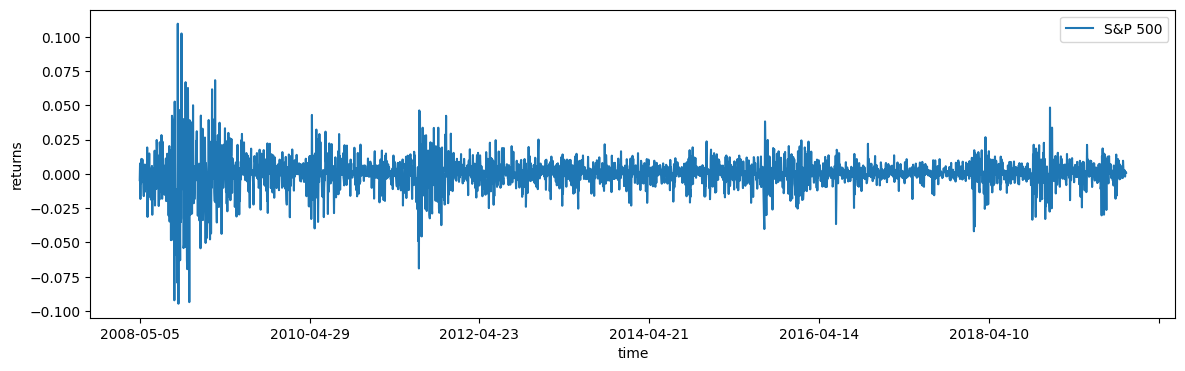

In [3]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

In [4]:
def make_stochastic_volatility_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, dims="time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT(
            "returns", nu=nu, lam=np.exp(-2 * volatility), observed=data["change"], dims="time"
        )
    return model


stochastic_vol_model = make_stochastic_volatility_model(returns)

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/pymc/distributions/timeseries.py:292: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


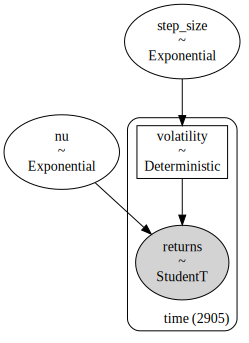

In [5]:
pm.model_to_graphviz(stochastic_vol_model)

In [6]:
with stochastic_vol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = idata.prior_predictive.stack(pooled_chain=("chain", "draw"))


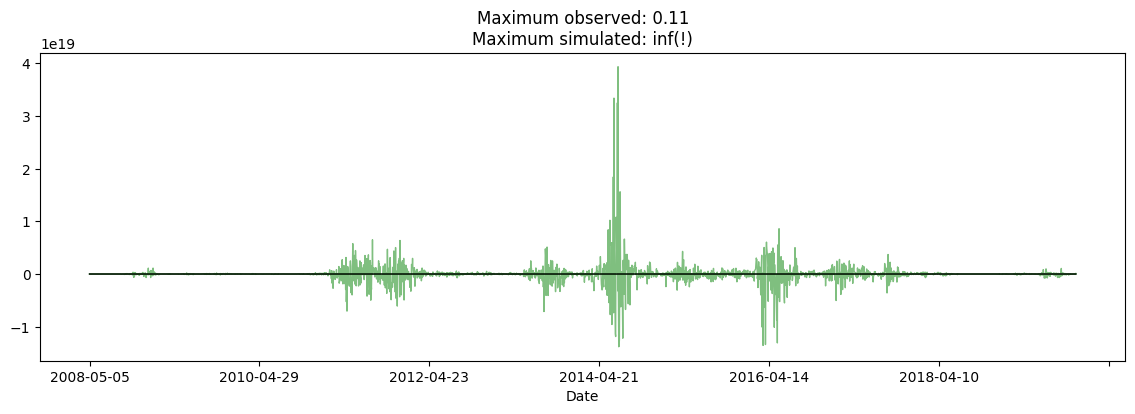

In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
returns["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

In [8]:
with stochastic_vol_model:
    idata.extend(pm.sample(2000, tune=2000, random_seed=rng))

posterior = idata.posterior.stack(pooled_chain=("chain", "draw"))
posterior["exp_volatility"] = np.exp(posterior["volatility"])

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 874 seconds.
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(


In [9]:
with stochastic_vol_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

posterior_predictive = idata.posterior_predictive.stack(pooled_chain=("chain", "draw"))


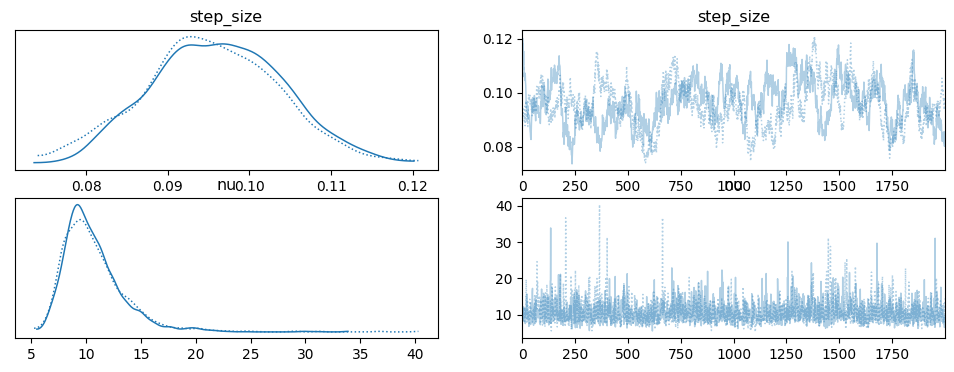

In [10]:
az.plot_trace(idata, var_names=["step_size", "nu"]);

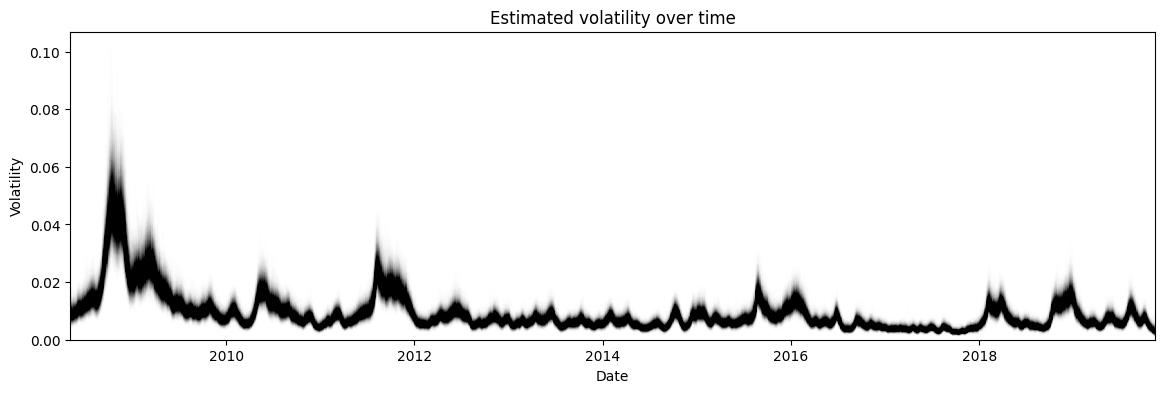

In [11]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

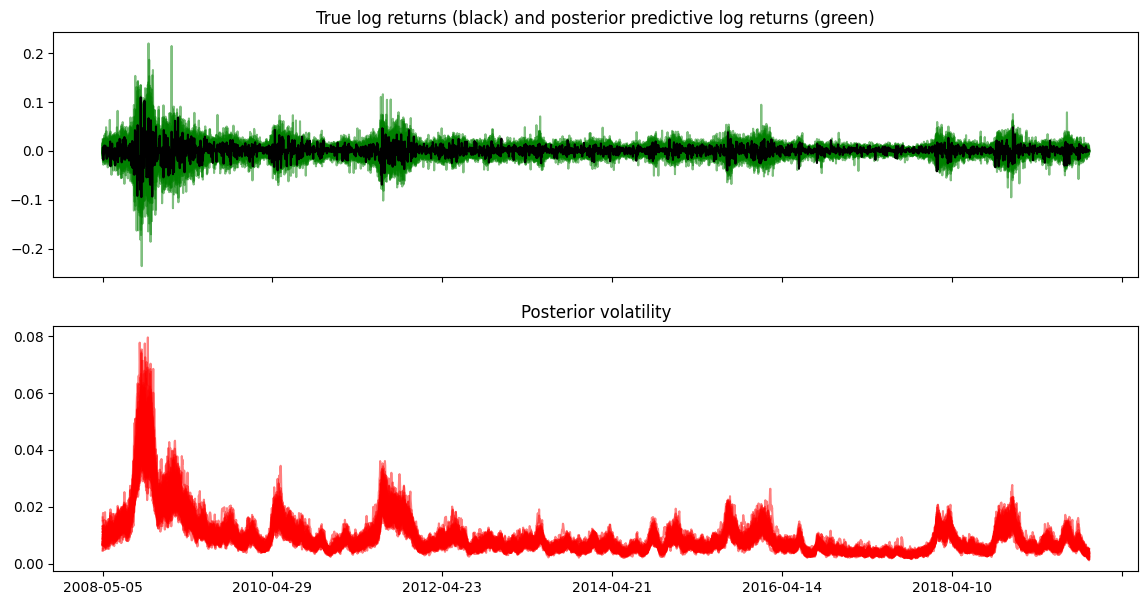

In [12]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns["change"].plot(ax=axes[0], color="black")

axes[1].plot(posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
axes[0].plot(
    posterior_predictive["returns"].isel(pooled_chain=slice(None, None, 100)),
    "g",
    alpha=0.5,
    zorder=-10,
)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");

# SGLD Torch Models


$X_i = log(r_i)$

Probability Model:

$$
\begin{align}
p(s_i, \nu, \sigma | {\bf x}) &= [\Pi_i p(x_i | s_i, \nu, \sigma) p(s_i | s_{i-1}, \sigma)] p(\nu) p(\sigma) \\
\\
p(x_i | s_i, \nu, \sigma) &\sim t(\nu, 0, exp(s_i)) \\
p(s_i|s_{i-1}, \sigma) &\sim N(s_{i-1}, \sigma) = N(0, \sigma) + s_{i-1} \\
p(\sigma) &\sim Exp(10) \\
p(\nu) &\sim Exp(0.1) \\
\end{align}
$$


Approximate $p(s_i|s_{i-1},\sigma, D) \approx q(s_i|\sigma, \mu_i) = s_{i-1} + N(\mu_i, \sigma)$ where $\mu_i$ is one of the parameters that is estimated by SGLD.




KL Loss:
$$
\begin{align}
KL[q({\bf s}|\sigma, \mu_i) || p({\bf s}| \sigma, \nu, x_i)] &= E_q[\log\frac{q({\bf s}|\sigma, \mu_i)}{p({\bf s, x}| \sigma, \nu)}] + \log p({\bf x}| \sigma, \nu) 
\end{align}
$$


ELBO Loss:
$$
\begin{align}
\log p(x_i| s_{i-1}, \sigma, \nu) &\geq -E_q[\log\frac{q(s_i|\sigma, \mu_i)}{p(s_i, x_i|s_{i-1}, \sigma, \nu)}] \\
&= E_q[\log p(s_i, x_i|s_{i-1}, \sigma, \nu) - \log q(s_i|\sigma, \mu_i)] \\
&= E_q[\log p(x_i|s_i, \sigma, \nu) + \log p(s_i | s_{i-1}, \sigma, \nu) - \log q(s_i|\sigma, \mu_i)]\\
&= E_q[\log p(x_i|s_i, \sigma, \nu) + \log p(s_i | s_{i-1}, \sigma) - \log q(s_i|\sigma, \mu_i)]\\
\end{align}
$$

ELBO over all time frames:

$$
\begin{align}
\sum_i \log p(x_i | s_{i-1}, \sigma, \nu)
\end{align}
$$


In [13]:
class StochasticVolatility(nn.Module):
    EPSILON = 1e-6
    
    def __init__(self, shape, sigma_lambda=10., nu_lambda=0.1):
        '''
            Args:
                shape: shape of observed variables; first dim is batch_size
                sigma_lamda: rate parameter of Exponential prior RV of stepsize (aka sigma)
                nu_lamda: rate parameter of Exponential prior RV of degree freedom
        '''
        super(StochasticVolatility, self).__init__()
        self.shape = shape
        
        self.prior_sigma_rv = distributions.Exponential(sigma_lambda)
        self.sigma = nn.Parameter(torch.tensor(1 / sigma_lambda))
        
        self.prior_nu_rv = distributions.Exponential(nu_lambda)
        self.nu = nn.Parameter(torch.tensor(1 / nu_lambda))
        
        self.vol_mean = nn.Parameter(torch.zeros(self.shape[1]))
        nn.init.normal_(self.vol_mean, std=0.0001)
        
        self.prior_init_rv = distributions.Normal(loc=torch.tensor(0.0), 
                                                  scale=torch.tensor(100.0))
        self.init_vol = nn.Parameter(torch.tensor(-4.5))
      
    def returns_rv(self, vol_samples):
        # Uses \sigma parameterization, not \lambda as PyMC model above
        # See: https://en.wikipedia.org/wiki/Student%27s_t-distribution#In_terms_of_scaling_parameter_%CF%83%CC%82_or_%CF%83%CC%822
        rv = distributions.StudentT(df=self.nu + self.EPSILON * torch.ones(vol_samples.shape), 
                                    loc=torch.zeros(vol_samples.shape), 
                                    scale=torch.exp(vol_samples) + self.EPSILON)
        return rv
   
    @property
    def q_vol_rv(self):
        return distributions.Normal(torch.stack([self.vol_mean] * self.shape[0]),
                                    self.sigma * torch.ones(self.shape))

    def forward(self):
        vol_diffs = self.q_vol_rv.rsample()
        vol_samples = self.init_vol + torch.cumsum(vol_diffs, dim=1)

        return self.returns_rv(vol_samples).mean, vol_samples

    def loss(self, r_obs, vol_samples):
        likelihood = self.returns_rv(vol_samples).log_prob(r_obs)
        
        vol_rv = distributions.Normal(loc=torch.zeros(vol_samples.shape),
                                      scale=self.sigma * torch.ones(vol_samples.shape))
        vol_diffs = torch.diff(vol_samples - self.init_vol, prepend=torch.zeros(self.shape[0], 1)) 
        vol_prior = vol_rv.log_prob(vol_diffs)
        q_loss = self.q_vol_rv.log_prob(vol_diffs)
       
        sigma_prior = self.prior_sigma_rv.log_prob(self.sigma)
        nu_prior = self.prior_nu_rv.log_prob(self.nu)
        init_loss = self.prior_init_rv.log_prob(self.init_vol)
        
        print(f'll = {likelihood.sum():.3f}, '
              f'vol_prior = {vol_prior.sum():.3f},'
              f'q_loss = {q_loss.sum():.3f},\n'
              f'sigma_prior = {sigma_prior.sum():.3f},'
              f'nu_prior = {nu_prior.sum():.3f}, '
              f'init_prior = {init_loss.sum():.3f}, '
             )
        return -(likelihood.sum() + sigma_prior.sum() + nu_prior.sum() - q_loss.sum()) / self.shape[0]

# Stochastic Gradient Descent

In [14]:
batch_size = 100


torch_data = torch.tensor(returns['change'])
torch_data = torch.stack([torch_data] * batch_size, 0)

torch_data, torch_data.shape

(tensor([[-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         ...,
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008]],
        dtype=torch.float64),
 torch.Size([100, 2905]))

ll = -609491.944, vol_prior = 257262.734,q_loss = 257262.500,
sigma_prior = 1.303,nu_prior = -3.303, init_prior = -5.525, 
[epoch=1] loss: 8667.56444
nu = 9.989999771118164
sigma = 0.09000000357627869
ll = -3219394.842, vol_prior = 285684.375,q_loss = 287467.531,
sigma_prior = 1.403,nu_prior = -3.302, init_prior = -5.525, 
[epoch=2] loss: 35068.64273
nu = 9.990028381347656
sigma = 0.09146939218044281
ll = -643020.097, vol_prior = 282226.000,q_loss = 282489.906,
sigma_prior = 1.388,nu_prior = -3.302, init_prior = -5.525, 
[epoch=3] loss: 9255.11917
nu = 9.989094734191895
sigma = 0.08911670744419098
ll = -1889202.912, vol_prior = 290428.438,q_loss = 290447.781,
sigma_prior = 1.411,nu_prior = -3.301, init_prior = -5.525, 
[epoch=4] loss: 21796.52583
nu = 9.979866981506348
sigma = 0.08032503724098206
ll = -2520586.515, vol_prior = 318509.344,q_loss = 320145.500,
sigma_prior = 1.499,nu_prior = -3.301, init_prior = -5.525, 
[epoch=5] loss: 28407.33816
nu = 9.979881286621094
sigma = 0.0811591

[epoch=43] loss: -132.36231
nu = 9.957440376281738
sigma = 0.03697759285569191
ll = 527934.205, vol_prior = 544650.125,q_loss = 545806.375,
sigma_prior = 1.933,nu_prior = -3.298, init_prior = -5.525, 
[epoch=44] loss: 178.73536
nu = 9.95633316040039
sigma = 0.03529425710439682
ll = 234871.700, vol_prior = 557389.938,q_loss = 559022.625,
sigma_prior = 1.950,nu_prior = -3.298, init_prior = -5.525, 
[epoch=45] loss: 3241.52274
nu = 9.95634651184082
sigma = 0.036005351692438126
ll = 621838.985, vol_prior = 552903.625,q_loss = 554135.375,
sigma_prior = 1.943,nu_prior = -3.298, init_prior = -5.525, 
[epoch=46] loss: -677.02254
nu = 9.955716133117676
sigma = 0.03458002582192421
ll = 567275.548, vol_prior = 563473.125,q_loss = 564886.312,
sigma_prior = 1.957,nu_prior = -3.298, init_prior = -5.525, 
[epoch=47] loss: -23.87895
nu = 9.95569133758545
sigma = 0.035123229026794434
ll = 520825.775, vol_prior = 559289.938,q_loss = 560800.625,
sigma_prior = 1.951,nu_prior = -3.298, init_prior = -5.525,

[epoch=86] loss: -459.34323
nu = 9.9419584274292
sigma = 0.02834625169634819
ll = 595001.980, vol_prior = 617942.625,q_loss = 623075.562,
sigma_prior = 2.019,nu_prior = -3.297, init_prior = -5.525, 
[epoch=87] loss: 280.74860
nu = 9.9408540725708
sigma = 0.026725580915808678
ll = 449498.912, vol_prior = 634222.875,q_loss = 640174.250,
sigma_prior = 2.035,nu_prior = -3.297, init_prior = -5.525, 
[epoch=88] loss: 1906.76600
nu = 9.940877914428711
sigma = 0.027920398861169815
ll = 728452.160, vol_prior = 622154.125,q_loss = 627649.250,
sigma_prior = 2.023,nu_prior = -3.297, init_prior = -5.525, 
[epoch=89] loss: -1008.01636
nu = 9.94040298461914
sigma = 0.027172332629561424
ll = 668725.127, vol_prior = 629466.125,q_loss = 635413.000,
sigma_prior = 2.031,nu_prior = -3.297, init_prior = -5.525, 
[epoch=90] loss: -333.10861
nu = 9.940393447875977
sigma = 0.028064681217074394
ll = 562552.897, vol_prior = 620208.625,q_loss = 625955.000,
sigma_prior = 2.022,nu_prior = -3.297, init_prior = -5.52

[epoch=129] loss: 145.08764
nu = 9.926932334899902
sigma = 0.028358859941363335
ll = 711352.746, vol_prior = 614187.500,q_loss = 622437.125,
sigma_prior = 2.019,nu_prior = -3.295, init_prior = -5.525, 
[epoch=130] loss: -889.14345
nu = 9.926191329956055
sigma = 0.027399111539125443
ll = 636382.114, vol_prior = 623904.938,q_loss = 632617.312,
sigma_prior = 2.029,nu_prior = -3.295, init_prior = -5.525, 
[epoch=131] loss: -37.63535
nu = 9.926183700561523
sigma = 0.02832939848303795
ll = 708077.549, vol_prior = 614832.500,q_loss = 623267.625,
sigma_prior = 2.019,nu_prior = -3.295, init_prior = -5.525, 
[epoch=132] loss: -848.08649
nu = 9.925431251525879
sigma = 0.027500398457050323
ll = 580030.557, vol_prior = 623551.000,q_loss = 632379.938,
sigma_prior = 2.028,nu_prior = -3.295, init_prior = -5.525, 
[epoch=133] loss: 523.50648
nu = 9.925454139709473
sigma = 0.028675617650151253
ll = 747948.188, vol_prior = 610520.875,q_loss = 618862.875,
sigma_prior = 2.016,nu_prior = -3.295, init_prior 

[epoch=172] loss: 383.75977
nu = 9.90980052947998
sigma = 0.0255312267690897
ll = 450930.388, vol_prior = 639539.625,q_loss = 653354.000,
sigma_prior = 2.047,nu_prior = -3.294, init_prior = -5.525, 
[epoch=173] loss: 2024.24858
nu = 9.909838676452637
sigma = 0.026681547984480858
ll = 781122.970, vol_prior = 627439.312,q_loss = 640109.625,
sigma_prior = 2.036,nu_prior = -3.294, init_prior = -5.525, 
[epoch=174] loss: -1410.12088
nu = 9.909346580505371
sigma = 0.02631351910531521
ll = 758227.513, vol_prior = 631931.750,q_loss = 644702.688,
sigma_prior = 2.039,nu_prior = -3.294, init_prior = -5.525, 
[epoch=175] loss: -1135.23572
nu = 9.909284591674805
sigma = 0.027145331725478172
ll = 717232.603, vol_prior = 623170.812,q_loss = 635297.625,
sigma_prior = 2.031,nu_prior = -3.294, init_prior = -5.525, 
[epoch=176] loss: -819.33716
nu = 9.90848445892334
sigma = 0.02623101696372032
ll = 637950.733, vol_prior = 632098.438,q_loss = 645290.500,
sigma_prior = 2.040,nu_prior = -3.293, init_prior =

ll = 731612.898, vol_prior = 621248.188,q_loss = 635612.250,
sigma_prior = 2.031,nu_prior = -3.292, init_prior = -5.525, 
[epoch=215] loss: -959.99387
nu = 9.891294479370117
sigma = 0.026248980313539505
ll = 683370.067, vol_prior = 629874.188,q_loss = 645603.938,
sigma_prior = 2.040,nu_prior = -3.292, init_prior = -5.525, 
[epoch=216] loss: -377.64878
nu = 9.891315460205078
sigma = 0.027466947212815285
ll = 663930.497, vol_prior = 617740.938,q_loss = 632077.250,
sigma_prior = 2.028,nu_prior = -3.292, init_prior = -5.525, 
[epoch=217] loss: -318.51983
nu = 9.890029907226562
sigma = 0.02613469772040844
ll = 513921.513, vol_prior = 631306.375,q_loss = 646997.188,
sigma_prior = 2.041,nu_prior = -3.292, init_prior = -5.525, 
[epoch=218] loss: 1330.76925
nu = 9.8900728225708
sigma = 0.02752479910850525
ll = 736489.229, vol_prior = 616856.750,q_loss = 631004.375,
sigma_prior = 2.027,nu_prior = -3.292, init_prior = -5.525, 
[epoch=219] loss: -1054.83590
nu = 9.889366149902344
sigma = 0.0267891

[epoch=257] loss: -334.60259
nu = 9.869590759277344
sigma = 0.02570125088095665
ll = 527047.587, vol_prior = 633063.000,q_loss = 651315.375,
sigma_prior = 2.046,nu_prior = -3.290, init_prior = -5.525, 
[epoch=258] loss: 1242.69031
nu = 9.86961841583252
sigma = 0.02685810998082161
ll = 758699.775, vol_prior = 621927.562,q_loss = 638596.000,
sigma_prior = 2.034,nu_prior = -3.290, init_prior = -5.525, 
[epoch=259] loss: -1201.02519
nu = 9.868963241577148
sigma = 0.026346344500780106
ll = 780167.749, vol_prior = 626663.688,q_loss = 644184.000,
sigma_prior = 2.039,nu_prior = -3.289, init_prior = -5.525, 
[epoch=260] loss: -1359.82498
nu = 9.868915557861328
sigma = 0.02721479907631874
ll = 693311.723, vol_prior = 617906.125,q_loss = 635065.688,
sigma_prior = 2.030,nu_prior = -3.289, init_prior = -5.525, 
[epoch=261] loss: -582.44776
nu = 9.867642402648926
sigma = 0.026055796071887016
ll = 462252.572, vol_prior = 629244.188,q_loss = 647491.938,
sigma_prior = 2.042,nu_prior = -3.289, init_prio

ll = 786795.691, vol_prior = 620600.375,q_loss = 640108.250,
sigma_prior = 2.035,nu_prior = -3.287, init_prior = -5.525, 
[epoch=300] loss: -1466.86189
nu = 9.848528861999512
sigma = 0.02710002101957798
sigma = 0.02710002101957798
nu = 9.848528861999512
vol_mean = Parameter containing:
tensor([ 0.0057,  0.0059,  0.0057,  ..., -0.1620, -0.2152, -0.1775],
       requires_grad=True)
init_vol = -4.494253635406494


<AxesSubplot: >

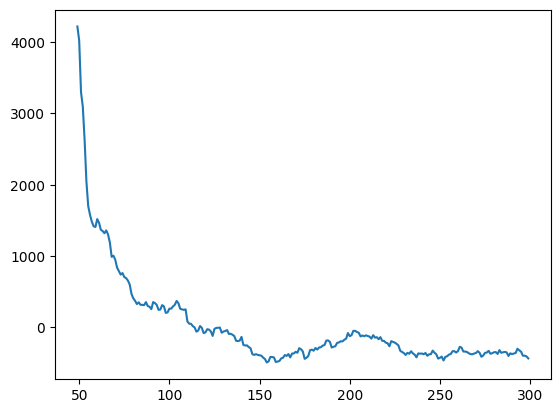

In [15]:
torch.manual_seed(0)
np.random.seed(0)

torch_model = StochasticVolatility(torch_data.shape, sigma_lambda=10., nu_lambda=0.1)
lr = 0.001
optimizer = optim.RMSprop(torch_model.parameters(), lr=lr)

epoch = 0
loss_seq = []
for epoch in range(300):
    print(f'========================================')
    torch_model.zero_grad()
    
    r_samples, vol_samples = torch_model()
    loss = torch_model.loss(torch_data, vol_samples)
    loss.backward()
    optimizer.step()

    print(f'[epoch={epoch+1}] loss: {loss.item():.5f}')
    print(f'nu = {torch_model.nu}')
    print(f'sigma = {torch_model.sigma}')
    loss_seq.append(loss.item())
        
print(f'========================================')
for name, param in torch_model.named_parameters():
    print(f'{name} = {param}')

loss_seq = pd.Series(loss_seq)
loss_seq.rolling(50).mean().plot()

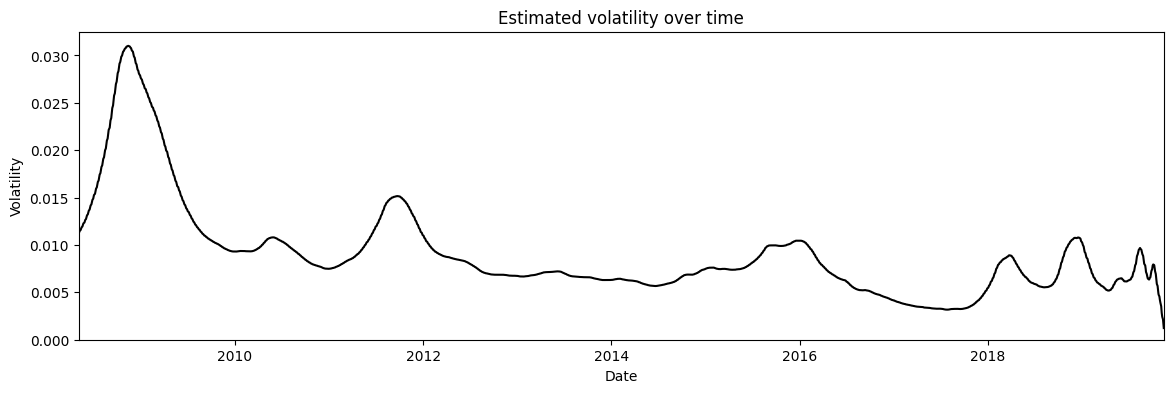

In [16]:
sigma_rv = distributions.Exponential(torch_model.sigma)
sigma_mean = sigma_rv.mean

vol_mean = torch_model.init_vol + torch.cumsum(torch_model.vol_mean, dim=0) 

fig, ax = plt.subplots(figsize=(14, 4))
y_vals = np.exp(vol_mean.cpu().detach().numpy())
x_vals = returns.index.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k")#, alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

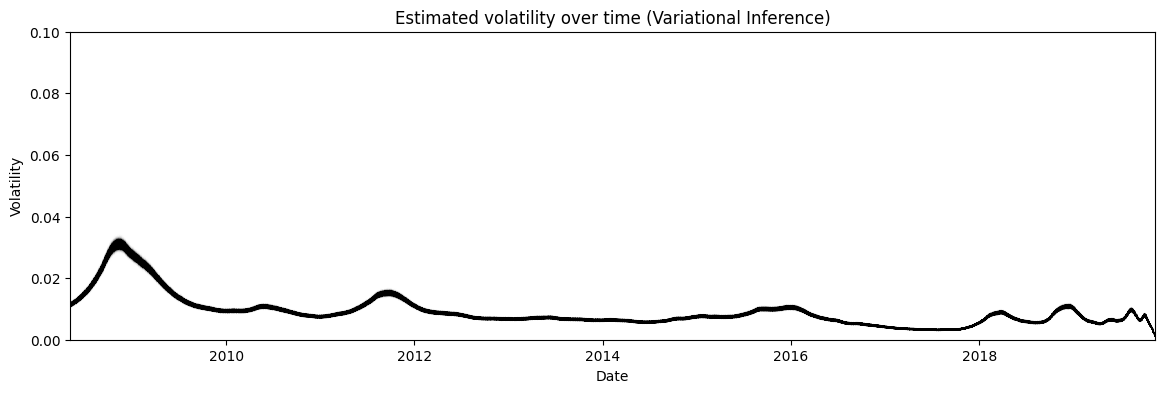

In [17]:
vol_mean = torch_model.init_vol + torch.cumsum(torch_model.vol_mean, dim=0) 

vol_rv = distributions.Normal(vol_mean, torch_model.sigma)
vol_samples = vol_rv.sample([1000]).transpose(0, 1)

fig, ax = plt.subplots(figsize=(14, 4))
y_vals = np.exp(vol_samples.cpu().detach().numpy())
x_vals = returns.index.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(top=0.10, bottom=0)
ax.set(title="Estimated volatility over time (Variational Inference)", xlabel="Date", ylabel="Volatility");

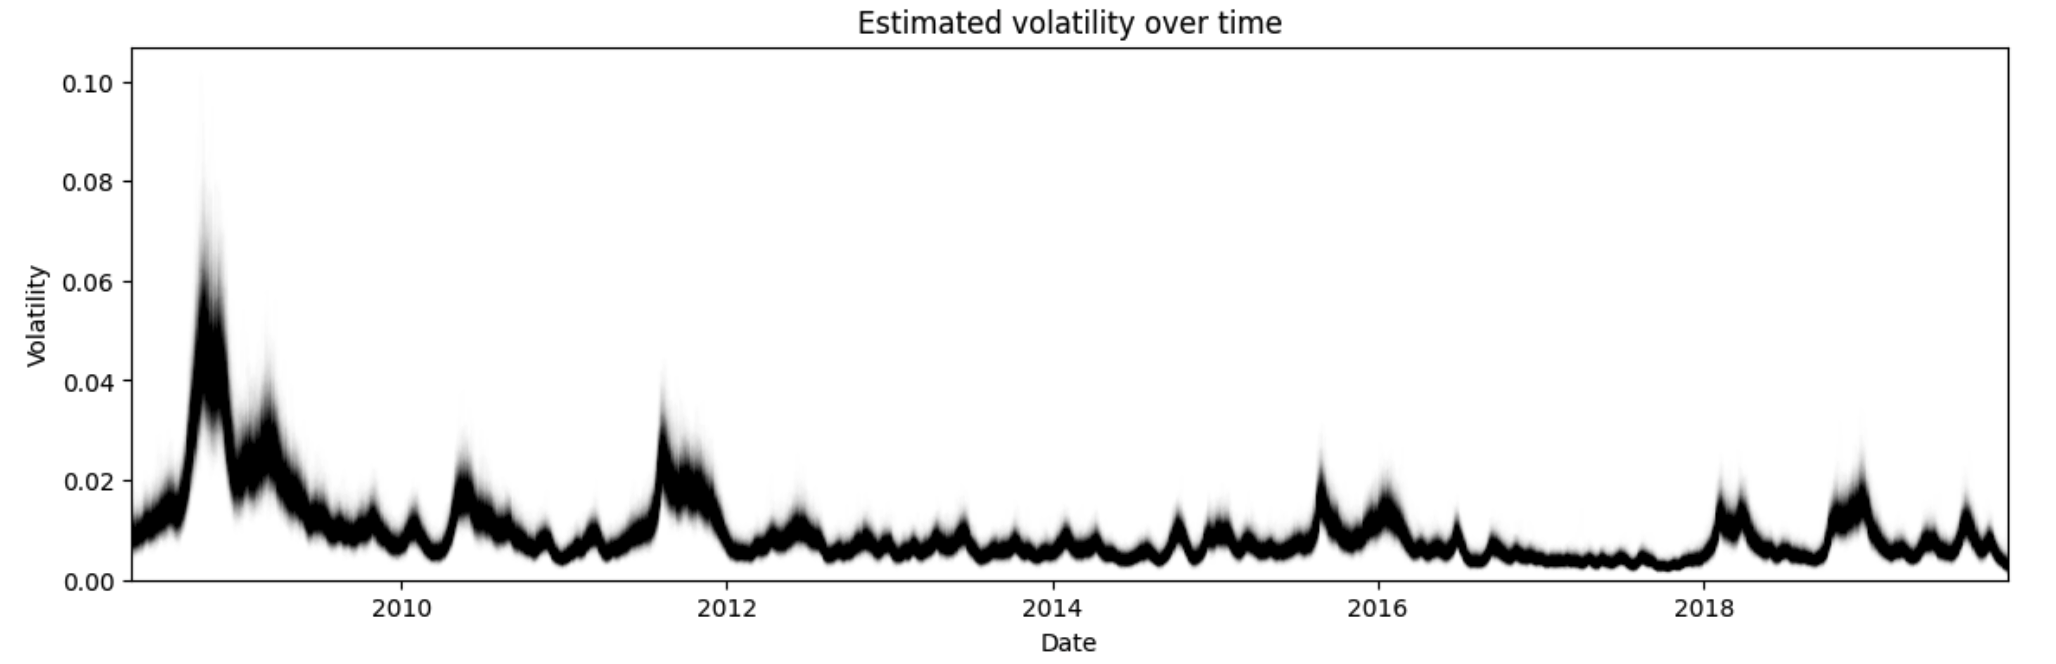

# Stochastic Gradient Langevin Dynamics

In [18]:
class SGLD(torch.optim.RMSprop):
    def __init__(self, *args, **kwargs):
        super(SGLD, self).__init__(*args, **kwargs)
        
    def step(self, *args, **kwargs):
        loss = super().step(*args, **kwargs)
       
        with torch.no_grad():
            for group in self.param_groups:
                assert group['momentum'] == 0, "momentum not supported"
                assert group['centered'] == 0, "centered not supported"
                assert group['weight_decay'] == 0, "weight_decay not supported"
                
                lr = group['lr']
                for p in group['params']:
                    assert not torch.is_complex(p), "complex not supported"
                    state = self.state[p]
                    square_avg = state['square_avg']
                
                    avg = square_avg.sqrt()
                    avg = avg.add_(group['eps'])
                
                    effective_lr = 2 * lr / avg
                    m = distributions.Normal(torch.zeros(p.shape), torch.ones(p.shape))
                    noise = m.sample() * effective_lr.sqrt()
                    p.sub_(noise)
        
        return loss

In [19]:
def compute_lr(epoch, burnin=1000, start=0.001, gamma=0.55):
    if epoch < burnin:
        return start
    
    epoch = epoch - burnin
    b = 1
    return start * ((b + epoch) ** (-gamma))

for i in [0, 2000, 5000, 10000]:
    print(f't={i:05d}: {compute_lr(i):8f}')

t=00000: 0.001000
t=02000: 0.000022
t=05000: 0.000010
t=10000: 0.000007


ll = -609491.944, vol_prior = 257262.734,q_loss = 257262.500,
sigma_prior = 1.303,nu_prior = -3.303, init_prior = -5.525, 
[epoch=1] loss: 8667.56444, last_lr: [0.001]
ll = -3355702.166, vol_prior = 283692.812,q_loss = 287165.406,
sigma_prior = 1.401,nu_prior = -3.301, init_prior = -5.525, 
[epoch=2] loss: 36428.69472, last_lr: [0.001]
ll = -642848.261, vol_prior = 281242.000,q_loss = 283848.312,
sigma_prior = 1.393,nu_prior = -3.301, init_prior = -5.525, 
[epoch=3] loss: 9266.98481, last_lr: [0.001]
ll = -1083535.245, vol_prior = 288708.000,q_loss = 290823.469,
sigma_prior = 1.417,nu_prior = -3.301, init_prior = -5.525, 
[epoch=4] loss: 13743.60598, last_lr: [0.001]
ll = -2265434.703, vol_prior = 317217.688,q_loss = 321193.875,
sigma_prior = 1.503,nu_prior = -3.300, init_prior = -5.525, 
[epoch=5] loss: 25866.30375, last_lr: [0.001]
ll = -864408.563, vol_prior = 314162.938,q_loss = 317554.625,
sigma_prior = 1.491,nu_prior = -3.300, init_prior = -5.525, 
[epoch=6] loss: 11819.64997, la

ll = 652668.050, vol_prior = 461756.031,q_loss = 542211.875,
sigma_prior = 1.929,nu_prior = -3.298, init_prior = -5.525, 
[epoch=42] loss: -1104.54807, last_lr: [0.001]
ll = 673609.968, vol_prior = 467002.312,q_loss = 546457.812,
sigma_prior = 1.934,nu_prior = -3.297, init_prior = -5.525, 
[epoch=43] loss: -1271.50792, last_lr: [0.001]
ll = 663549.456, vol_prior = 471880.812,q_loss = 554007.062,
sigma_prior = 1.943,nu_prior = -3.298, init_prior = -5.525, 
[epoch=44] loss: -1095.41039, last_lr: [0.001]
ll = 602086.388, vol_prior = 466175.438,q_loss = 559790.062,
sigma_prior = 1.950,nu_prior = -3.298, init_prior = -5.525, 
[epoch=45] loss: -422.94978, last_lr: [0.001]
ll = 699315.673, vol_prior = 467450.062,q_loss = 567691.875,
sigma_prior = 1.959,nu_prior = -3.297, init_prior = -5.525, 
[epoch=46] loss: -1316.22460, last_lr: [0.001]
ll = 676809.311, vol_prior = 464014.000,q_loss = 572664.875,
sigma_prior = 1.965,nu_prior = -3.297, init_prior = -5.525, 
[epoch=47] loss: -1041.43104, last

[epoch=87] loss: 4576.21833, last_lr: [0.001]
ll = 714067.864, vol_prior = 447836.625,q_loss = 626623.750,
sigma_prior = 2.023,nu_prior = -3.296, init_prior = -5.525, 
[epoch=88] loss: -874.42840, last_lr: [0.001]
ll = 644200.350, vol_prior = 444759.844,q_loss = 620831.625,
sigma_prior = 2.017,nu_prior = -3.296, init_prior = -5.525, 
[epoch=89] loss: -233.67445, last_lr: [0.001]
ll = 438832.857, vol_prior = 439141.656,q_loss = 634548.625,
sigma_prior = 2.031,nu_prior = -3.296, init_prior = -5.525, 
[epoch=90] loss: 1957.17033, last_lr: [0.001]
ll = 781876.906, vol_prior = 440848.594,q_loss = 621437.562,
sigma_prior = 2.018,nu_prior = -3.296, init_prior = -5.525, 
[epoch=91] loss: -1604.38065, last_lr: [0.001]
ll = 728764.359, vol_prior = 445367.031,q_loss = 622608.625,
sigma_prior = 2.018,nu_prior = -3.296, init_prior = -5.525, 
[epoch=92] loss: -1061.54456, last_lr: [0.001]
ll = 784060.819, vol_prior = 442981.469,q_loss = 630589.250,
sigma_prior = 2.026,nu_prior = -3.296, init_prior =

ll = 731526.508, vol_prior = 407713.938,q_loss = 625927.625,
sigma_prior = 2.022,nu_prior = -3.296, init_prior = -5.525, 
[epoch=134] loss: -1055.97609, last_lr: [0.001]
ll = 777868.069, vol_prior = 412505.344,q_loss = 625681.500,
sigma_prior = 2.022,nu_prior = -3.296, init_prior = -5.525, 
[epoch=135] loss: -1521.85295, last_lr: [0.001]
ll = 645740.485, vol_prior = 414212.875,q_loss = 631293.688,
sigma_prior = 2.027,nu_prior = -3.296, init_prior = -5.525, 
[epoch=136] loss: -144.45528, last_lr: [0.001]
ll = 685369.729, vol_prior = 417822.562,q_loss = 622863.438,
sigma_prior = 2.019,nu_prior = -3.297, init_prior = -5.525, 
[epoch=137] loss: -625.05014, last_lr: [0.001]
ll = 602745.229, vol_prior = 403131.844,q_loss = 635804.625,
sigma_prior = 2.031,nu_prior = -3.297, init_prior = -5.525, 
[epoch=138] loss: 330.60662, last_lr: [0.001]
ll = 671026.474, vol_prior = 407475.406,q_loss = 625142.875,
sigma_prior = 2.022,nu_prior = -3.297, init_prior = -5.525, 
[epoch=139] loss: -458.82324, la

[epoch=179] loss: 468.91499, last_lr: [0.001]
ll = 762894.395, vol_prior = 332412.000,q_loss = 630650.562,
sigma_prior = 2.027,nu_prior = -3.295, init_prior = -5.525, 
[epoch=180] loss: -1322.42565, last_lr: [0.001]
ll = 733133.658, vol_prior = 325057.281,q_loss = 637328.688,
sigma_prior = 2.032,nu_prior = -3.295, init_prior = -5.525, 
[epoch=181] loss: -958.03708, last_lr: [0.001]
ll = 764428.149, vol_prior = 322874.594,q_loss = 640246.062,
sigma_prior = 2.036,nu_prior = -3.295, init_prior = -5.525, 
[epoch=182] loss: -1241.80827, last_lr: [0.001]
ll = 711753.298, vol_prior = 319238.906,q_loss = 643554.250,
sigma_prior = 2.039,nu_prior = -3.295, init_prior = -5.525, 
[epoch=183] loss: -681.97791, last_lr: [0.001]
ll = 635037.277, vol_prior = 323656.688,q_loss = 632775.312,
sigma_prior = 2.029,nu_prior = -3.296, init_prior = -5.525, 
[epoch=184] loss: -22.60698, last_lr: [0.001]
ll = 508221.348, vol_prior = 296734.156,q_loss = 652165.750,
sigma_prior = 2.046,nu_prior = -3.296, init_pri

[epoch=226] loss: -287.78700, last_lr: [0.001]
ll = 525794.952, vol_prior = 216899.453,q_loss = 650041.500,
sigma_prior = 2.044,nu_prior = -3.296, init_prior = -5.525, 
[epoch=227] loss: 1242.47800, last_lr: [0.001]
ll = 787077.218, vol_prior = 242278.375,q_loss = 636508.188,
sigma_prior = 2.032,nu_prior = -3.296, init_prior = -5.525, 
[epoch=228] loss: -1505.67767, last_lr: [0.001]
ll = 773198.973, vol_prior = 236610.828,q_loss = 639859.250,
sigma_prior = 2.035,nu_prior = -3.296, init_prior = -5.525, 
[epoch=229] loss: -1333.38462, last_lr: [0.001]
ll = 584338.683, vol_prior = 242100.938,q_loss = 632770.938,
sigma_prior = 2.029,nu_prior = -3.295, init_prior = -5.525, 
[epoch=230] loss: 484.33521, last_lr: [0.001]
ll = 283946.254, vol_prior = 195846.484,q_loss = 653553.000,
sigma_prior = 2.048,nu_prior = -3.295, init_prior = -5.525, 
[epoch=231] loss: 3696.07993, last_lr: [0.001]
ll = 739769.218, vol_prior = 223729.062,q_loss = 640647.375,
sigma_prior = 2.036,nu_prior = -3.295, init_pr

ll = 744154.994, vol_prior = 164303.656,q_loss = 630610.875,
sigma_prior = 2.026,nu_prior = -3.293, init_prior = -5.525, 
[epoch=272] loss: -1135.42852, last_lr: [0.001]
ll = 734783.796, vol_prior = 159650.594,q_loss = 631452.250,
sigma_prior = 2.027,nu_prior = -3.293, init_prior = -5.525, 
[epoch=273] loss: -1033.30281, last_lr: [0.001]
ll = 735994.587, vol_prior = 133984.281,q_loss = 640695.000,
sigma_prior = 2.036,nu_prior = -3.293, init_prior = -5.525, 
[epoch=274] loss: -952.98330, last_lr: [0.001]
ll = 757347.597, vol_prior = 139587.406,q_loss = 638666.688,
sigma_prior = 2.034,nu_prior = -3.293, init_prior = -5.525, 
[epoch=275] loss: -1186.79650, last_lr: [0.001]
ll = 739382.360, vol_prior = 122011.133,q_loss = 643988.188,
sigma_prior = 2.040,nu_prior = -3.294, init_prior = -5.525, 
[epoch=276] loss: -953.92918, last_lr: [0.001]
ll = 668809.081, vol_prior = 143841.438,q_loss = 638318.500,
sigma_prior = 2.033,nu_prior = -3.295, init_prior = -5.525, 
[epoch=277] loss: -304.89320, 

ll = 754824.970, vol_prior = 97132.188,q_loss = 627997.188,
sigma_prior = 2.023,nu_prior = -3.292, init_prior = -5.525, 
[epoch=318] loss: -1268.26514, last_lr: [0.001]
ll = 739903.296, vol_prior = 74630.047,q_loss = 635101.375,
sigma_prior = 2.031,nu_prior = -3.291, init_prior = -5.525, 
[epoch=319] loss: -1048.00661, last_lr: [0.001]
ll = 757002.271, vol_prior = 83285.594,q_loss = 630379.562,
sigma_prior = 2.027,nu_prior = -3.292, init_prior = -5.525, 
[epoch=320] loss: -1266.21444, last_lr: [0.001]
ll = 652861.886, vol_prior = 60853.836,q_loss = 637564.000,
sigma_prior = 2.033,nu_prior = -3.291, init_prior = -5.525, 
[epoch=321] loss: -152.96628, last_lr: [0.001]
ll = 699742.643, vol_prior = 98279.516,q_loss = 624577.375,
sigma_prior = 2.021,nu_prior = -3.292, init_prior = -5.525, 
[epoch=322] loss: -751.63998, last_lr: [0.001]
ll = 510492.144, vol_prior = 59857.336,q_loss = 637174.250,
sigma_prior = 2.033,nu_prior = -3.291, init_prior = -5.525, 
[epoch=323] loss: 1266.83364, last_l

ll = 671751.008, vol_prior = 56968.043,q_loss = 637168.938,
sigma_prior = 2.032,nu_prior = -3.292, init_prior = -5.525, 
[epoch=363] loss: -345.80811, last_lr: [0.001]
ll = 398664.419, vol_prior = 5071.781,q_loss = 651343.500,
sigma_prior = 2.045,nu_prior = -3.292, init_prior = -5.525, 
[epoch=364] loss: 2526.80327, last_lr: [0.001]
ll = 773767.089, vol_prior = 50310.301,q_loss = 633929.062,
sigma_prior = 2.030,nu_prior = -3.293, init_prior = -5.525, 
[epoch=365] loss: -1398.36764, last_lr: [0.001]
ll = 755441.728, vol_prior = 41476.691,q_loss = 637753.500,
sigma_prior = 2.033,nu_prior = -3.293, init_prior = -5.525, 
[epoch=366] loss: -1176.86968, last_lr: [0.001]
ll = 783652.378, vol_prior = 32849.711,q_loss = 640707.750,
sigma_prior = 2.036,nu_prior = -3.293, init_prior = -5.525, 
[epoch=367] loss: -1429.43371, last_lr: [0.001]
ll = 754906.468, vol_prior = 18489.510,q_loss = 642310.875,
sigma_prior = 2.038,nu_prior = -3.292, init_prior = -5.525, 
[epoch=368] loss: -1125.94339, last_l

[epoch=402] loss: -753.23075, last_lr: [0.001]
ll = 714460.430, vol_prior = -69086.414,q_loss = 645329.250,
sigma_prior = 2.040,nu_prior = -3.290, init_prior = -5.525, 
[epoch=403] loss: -691.29930, last_lr: [0.001]
ll = 459418.413, vol_prior = -113252.398,q_loss = 657942.125,
sigma_prior = 2.051,nu_prior = -3.291, init_prior = -5.525, 
[epoch=404] loss: 1985.24951, last_lr: [0.001]
ll = 788787.993, vol_prior = -53258.586,q_loss = 640915.438,
sigma_prior = 2.036,nu_prior = -3.291, init_prior = -5.525, 
[epoch=405] loss: -1478.71301, last_lr: [0.001]
ll = 767210.689, vol_prior = -68382.812,q_loss = 645359.000,
sigma_prior = 2.041,nu_prior = -3.291, init_prior = -5.525, 
[epoch=406] loss: -1218.50439, last_lr: [0.001]
ll = 765731.775, vol_prior = -77599.680,q_loss = 646039.000,
sigma_prior = 2.041,nu_prior = -3.291, init_prior = -5.525, 
[epoch=407] loss: -1196.91525, last_lr: [0.001]
ll = 747725.675, vol_prior = -97880.023,q_loss = 650857.875,
sigma_prior = 2.045,nu_prior = -3.290, init

[epoch=442] loss: 919.06093, last_lr: [0.001]
ll = 727933.987, vol_prior = -8773.593,q_loss = 631055.875,
sigma_prior = 2.027,nu_prior = -3.288, init_prior = -5.525, 
[epoch=443] loss: -968.76852, last_lr: [0.001]
ll = 552343.187, vol_prior = -35855.027,q_loss = 638903.250,
sigma_prior = 2.034,nu_prior = -3.288, init_prior = -5.525, 
[epoch=444] loss: 865.61317, last_lr: [0.001]
ll = 652081.191, vol_prior = 7625.812,q_loss = 626586.438,
sigma_prior = 2.023,nu_prior = -3.288, init_prior = -5.525, 
[epoch=445] loss: -254.93488, last_lr: [0.001]
ll = 646946.477, vol_prior = -64831.094,q_loss = 648672.938,
sigma_prior = 2.044,nu_prior = -3.288, init_prior = -5.525, 
[epoch=446] loss: 17.27705, last_lr: [0.001]
ll = 725265.610, vol_prior = -25690.857,q_loss = 638529.562,
sigma_prior = 2.034,nu_prior = -3.289, init_prior = -5.525, 
[epoch=447] loss: -867.34793, last_lr: [0.001]
ll = 676874.553, vol_prior = -60581.805,q_loss = 647030.062,
sigma_prior = 2.041,nu_prior = -3.289, init_prior = -5

[epoch=487] loss: 19.98267, last_lr: [0.001]
ll = 691148.265, vol_prior = -124935.352,q_loss = 643888.375,
sigma_prior = 2.039,nu_prior = -3.286, init_prior = -5.525, 
[epoch=488] loss: -472.58643, last_lr: [0.001]
ll = 525515.561, vol_prior = -181243.000,q_loss = 657138.312,
sigma_prior = 2.051,nu_prior = -3.286, init_prior = -5.525, 
[epoch=489] loss: 1316.23987, last_lr: [0.001]
ll = 735112.024, vol_prior = -121228.000,q_loss = 642086.125,
sigma_prior = 2.037,nu_prior = -3.287, init_prior = -5.525, 
[epoch=490] loss: -930.24650, last_lr: [0.001]
ll = 659007.875, vol_prior = -176662.047,q_loss = 654785.500,
sigma_prior = 2.048,nu_prior = -3.286, init_prior = -5.525, 
[epoch=491] loss: -42.21137, last_lr: [0.001]
ll = 648503.307, vol_prior = -97298.625,q_loss = 638146.875,
sigma_prior = 2.033,nu_prior = -3.285, init_prior = -5.525, 
[epoch=492] loss: -103.55180, last_lr: [0.001]
ll = 333490.442, vol_prior = -181585.266,q_loss = 654939.125,
sigma_prior = 2.050,nu_prior = -3.285, init_p

ll = 789335.001, vol_prior = -138663.828,q_loss = 632147.750,
sigma_prior = 2.028,nu_prior = -3.281, init_prior = -5.525, 
[epoch=526] loss: -1571.85998, last_lr: [0.00016321118940000818]
ll = 752430.398, vol_prior = -134781.312,q_loss = 632228.625,
sigma_prior = 2.028,nu_prior = -3.281, init_prior = -5.525, 
[epoch=527] loss: -1202.00520, last_lr: [0.00015997903867748483]
ll = 752995.823, vol_prior = -128281.773,q_loss = 630566.375,
sigma_prior = 2.027,nu_prior = -3.282, init_prior = -5.525, 
[epoch=528] loss: -1224.28193, last_lr: [0.0001569210123174447]
ll = 776812.859, vol_prior = -136621.203,q_loss = 631959.875,
sigma_prior = 2.028,nu_prior = -3.281, init_prior = -5.525, 
[epoch=529] loss: -1448.51731, last_lr: [0.00015402219556410243]
ll = 787247.878, vol_prior = -140485.297,q_loss = 633249.688,
sigma_prior = 2.029,nu_prior = -3.281, init_prior = -5.525, 
[epoch=530] loss: -1539.96939, last_lr: [0.00015126939445850714]
ll = 767736.522, vol_prior = -138071.125,q_loss = 633864.000,

[epoch=566] loss: -1095.64217, last_lr: [9.900539447703534e-05]
ll = 792517.398, vol_prior = -204294.312,q_loss = 642871.000,
sigma_prior = 2.038,nu_prior = -3.280, init_prior = -5.525, 
[epoch=567] loss: -1496.45156, last_lr: [9.82019469103905e-05]
ll = 771052.236, vol_prior = -205086.812,q_loss = 642190.625,
sigma_prior = 2.038,nu_prior = -3.280, init_prior = -5.525, 
[epoch=568] loss: -1288.60370, last_lr: [9.741660722007101e-05]
ll = 734259.411, vol_prior = -201418.844,q_loss = 643019.250,
sigma_prior = 2.038,nu_prior = -3.280, init_prior = -5.525, 
[epoch=569] loss: -912.38920, last_lr: [9.664871361645355e-05]
ll = 797785.445, vol_prior = -209124.562,q_loss = 644360.688,
sigma_prior = 2.040,nu_prior = -3.280, init_prior = -5.525, 
[epoch=570] loss: -1534.23517, last_lr: [9.589763750575048e-05]
ll = 772949.031, vol_prior = -209453.578,q_loss = 644554.500,
sigma_prior = 2.039,nu_prior = -3.280, init_prior = -5.525, 
[epoch=571] loss: -1283.93290, last_lr: [9.516278138555346e-05]
ll 

ll = 783446.828, vol_prior = -239064.750,q_loss = 649283.062,
sigma_prior = 2.044,nu_prior = -3.279, init_prior = -5.525, 
[epoch=606] loss: -1341.62530, last_lr: [7.653127034779834e-05]
ll = 819951.938, vol_prior = -242303.281,q_loss = 650812.000,
sigma_prior = 2.045,nu_prior = -3.279, init_prior = -5.525, 
[epoch=607] loss: -1691.38704, last_lr: [7.614071214908505e-05]
ll = 799641.244, vol_prior = -242521.797,q_loss = 649236.875,
sigma_prior = 2.044,nu_prior = -3.279, init_prior = -5.525, 
[epoch=608] loss: -1504.03134, last_lr: [7.575571929292096e-05]
ll = 766485.462, vol_prior = -237548.156,q_loss = 649357.375,
sigma_prior = 2.043,nu_prior = -3.279, init_prior = -5.525, 
[epoch=609] loss: -1171.26852, last_lr: [7.537616249866717e-05]
ll = 790169.400, vol_prior = -251054.000,q_loss = 650143.125,
sigma_prior = 2.044,nu_prior = -3.279, init_prior = -5.525, 
[epoch=610] loss: -1400.25041, last_lr: [7.500191662879254e-05]
ll = 782874.637, vol_prior = -250104.844,q_loss = 650740.188,
sig

[epoch=646] loss: -1288.63685, last_lr: [6.426514117054952e-05]
ll = 802511.113, vol_prior = -266380.844,q_loss = 650678.250,
sigma_prior = 2.045,nu_prior = -3.278, init_prior = -5.525, 
[epoch=647] loss: -1518.31630, last_lr: [6.4025953744394e-05]
ll = 822937.143, vol_prior = -267047.594,q_loss = 650583.062,
sigma_prior = 2.045,nu_prior = -3.278, init_prior = -5.525, 
[epoch=648] loss: -1723.52848, last_lr: [6.378925828342524e-05]
ll = 797503.076, vol_prior = -255145.328,q_loss = 648587.875,
sigma_prior = 2.043,nu_prior = -3.278, init_prior = -5.525, 
[epoch=649] loss: -1489.13966, last_lr: [6.355501236034056e-05]
ll = 818064.357, vol_prior = -249728.469,q_loss = 647231.938,
sigma_prior = 2.042,nu_prior = -3.278, init_prior = -5.525, 
[epoch=650] loss: -1708.31184, last_lr: [6.332317454679639e-05]
ll = 761904.907, vol_prior = -242110.047,q_loss = 647244.500,
sigma_prior = 2.042,nu_prior = -3.278, init_prior = -5.525, 
[epoch=651] loss: -1146.59170, last_lr: [6.309370438346074e-05]
ll 

ll = 801358.776, vol_prior = -253221.562,q_loss = 645566.750,
sigma_prior = 2.040,nu_prior = -3.277, init_prior = -5.525, 
[epoch=687] loss: -1557.90789, last_lr: [5.61323446255362e-05]
ll = 760056.855, vol_prior = -256111.141,q_loss = 646094.375,
sigma_prior = 2.041,nu_prior = -3.277, init_prior = -5.525, 
[epoch=688] loss: -1139.61243, last_lr: [5.596880157177631e-05]
ll = 811326.562, vol_prior = -259008.766,q_loss = 646104.438,
sigma_prior = 2.041,nu_prior = -3.277, init_prior = -5.525, 
[epoch=689] loss: -1652.20888, last_lr: [5.5806594270403e-05]
ll = 741541.401, vol_prior = -261362.844,q_loss = 646077.750,
sigma_prior = 2.041,nu_prior = -3.277, init_prior = -5.525, 
[epoch=690] loss: -954.62415, last_lr: [5.564570486697448e-05]
ll = 814426.151, vol_prior = -266178.562,q_loss = 647846.312,
sigma_prior = 2.042,nu_prior = -3.277, init_prior = -5.525, 
[epoch=691] loss: -1665.78603, last_lr: [5.548611583755904e-05]
ll = 807538.390, vol_prior = -272261.938,q_loss = 648271.062,
sigma_p

ll = 793963.352, vol_prior = -312392.500,q_loss = 653525.125,
sigma_prior = 2.047,nu_prior = -3.277, init_prior = -5.525, 
[epoch=727] loss: -1404.36997, last_lr: [5.048191650070704e-05]
ll = 777420.054, vol_prior = -307073.688,q_loss = 651269.688,
sigma_prior = 2.046,nu_prior = -3.277, init_prior = -5.525, 
[epoch=728] loss: -1261.49135, last_lr: [5.0360552344013354e-05]
ll = 776988.515, vol_prior = -306017.375,q_loss = 651512.250,
sigma_prior = 2.045,nu_prior = -3.277, init_prior = -5.525, 
[epoch=729] loss: -1254.75033, last_lr: [5.024000687858174e-05]
ll = 812512.489, vol_prior = -304842.312,q_loss = 650584.875,
sigma_prior = 2.045,nu_prior = -3.277, init_prior = -5.525, 
[epoch=730] loss: -1619.26381, last_lr: [5.0120271058077176e-05]
ll = 809806.724, vol_prior = -303192.125,q_loss = 650730.750,
sigma_prior = 2.045,nu_prior = -3.277, init_prior = -5.525, 
[epoch=731] loss: -1590.74742, last_lr: [5.0001335974723985e-05]
ll = 765451.386, vol_prior = -301627.969,q_loss = 650072.000,


ll = 803976.232, vol_prior = -310342.750,q_loss = 649701.000,
sigma_prior = 2.044,nu_prior = -3.276, init_prior = -5.525, 
[epoch=768] loss: -1542.73999, last_lr: [4.609313484737748e-05]
ll = 764492.474, vol_prior = -310075.781,q_loss = 648775.000,
sigma_prior = 2.043,nu_prior = -3.276, init_prior = -5.525, 
[epoch=769] loss: -1157.16241, last_lr: [4.599916303963529e-05]
ll = 794623.946, vol_prior = -313240.438,q_loss = 648394.875,
sigma_prior = 2.043,nu_prior = -3.276, init_prior = -5.525, 
[epoch=770] loss: -1462.27837, last_lr: [4.590572915634151e-05]
ll = 775419.920, vol_prior = -318191.062,q_loss = 649282.875,
sigma_prior = 2.043,nu_prior = -3.276, init_prior = -5.525, 
[epoch=771] loss: -1261.35812, last_lr: [4.581282815027019e-05]
ll = 790537.978, vol_prior = -322890.562,q_loss = 648588.062,
sigma_prior = 2.043,nu_prior = -3.276, init_prior = -5.525, 
[epoch=772] loss: -1419.48682, last_lr: [4.572045503988213e-05]
ll = 759482.430, vol_prior = -327483.219,q_loss = 649112.188,
sig

ll = 785145.903, vol_prior = -371780.406,q_loss = 655157.750,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=806] loss: -1299.86925, last_lr: [4.2862144243589624e-05]
ll = 775838.930, vol_prior = -370140.156,q_loss = 656384.875,
sigma_prior = 2.050,nu_prior = -3.277, init_prior = -5.525, 
[epoch=807] loss: -1194.52828, last_lr: [4.2785548698751966e-05]
ll = 808766.177, vol_prior = -371161.156,q_loss = 655635.375,
sigma_prior = 2.050,nu_prior = -3.277, init_prior = -5.525, 
[epoch=808] loss: -1531.29574, last_lr: [4.270933765140884e-05]
ll = 794918.416, vol_prior = -369759.750,q_loss = 655894.000,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=809] loss: -1390.23189, last_lr: [4.263350793645662e-05]
ll = 820098.480, vol_prior = -381062.938,q_loss = 657146.062,
sigma_prior = 2.050,nu_prior = -3.277, init_prior = -5.525, 
[epoch=810] loss: -1629.51191, last_lr: [4.255805642494688e-05]
ll = 711488.614, vol_prior = -375675.031,q_loss = 655620.875,
s

[epoch=845] loss: -1309.71096, last_lr: [4.013360256845335e-05]
ll = 787567.284, vol_prior = -363650.875,q_loss = 656988.875,
sigma_prior = 2.051,nu_prior = -3.277, init_prior = -5.525, 
[epoch=846] loss: -1305.77183, last_lr: [4.0069948925340424e-05]
ll = 792241.824, vol_prior = -368306.250,q_loss = 657295.438,
sigma_prior = 2.051,nu_prior = -3.276, init_prior = -5.525, 
[epoch=847] loss: -1349.45160, last_lr: [4.00065789806676e-05]
ll = 763140.062, vol_prior = -356625.938,q_loss = 655870.438,
sigma_prior = 2.050,nu_prior = -3.276, init_prior = -5.525, 
[epoch=848] loss: -1072.68398, last_lr: [3.99434906602271e-05]
ll = 796934.911, vol_prior = -359352.312,q_loss = 656832.000,
sigma_prior = 2.050,nu_prior = -3.276, init_prior = -5.525, 
[epoch=849] loss: -1401.01685, last_lr: [3.98806819108631e-05]
ll = 766881.786, vol_prior = -356346.688,q_loss = 656106.500,
sigma_prior = 2.051,nu_prior = -3.277, init_prior = -5.525, 
[epoch=850] loss: -1107.74060, last_lr: [3.981815070019868e-05]
ll 

ll = 787669.056, vol_prior = -352502.500,q_loss = 653051.375,
sigma_prior = 2.047,nu_prior = -3.277, init_prior = -5.525, 
[epoch=885] loss: -1346.16451, last_lr: [3.7790007876006775e-05]
ll = 787597.490, vol_prior = -359941.250,q_loss = 653869.688,
sigma_prior = 2.047,nu_prior = -3.277, init_prior = -5.525, 
[epoch=886] loss: -1337.26573, last_lr: [3.773626988256521e-05]
ll = 778249.652, vol_prior = -371848.500,q_loss = 655248.250,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=887] loss: -1230.00174, last_lr: [3.768274668879591e-05]
ll = 797074.024, vol_prior = -374518.969,q_loss = 655422.250,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=888] loss: -1416.50546, last_lr: [3.762943688581287e-05]
ll = 782821.334, vol_prior = -376712.312,q_loss = 655859.250,
sigma_prior = 2.050,nu_prior = -3.277, init_prior = -5.525, 
[epoch=889] loss: -1269.60857, last_lr: [3.757633907756202e-05]
ll = 797509.498, vol_prior = -379759.562,q_loss = 655370.438,
si

[epoch=925] loss: -1121.26325, last_lr: [3.579519399818016e-05]
ll = 773814.070, vol_prior = -351048.062,q_loss = 655785.750,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=926] loss: -1180.27091, last_lr: [3.574906345401557e-05]
ll = 784646.649, vol_prior = -349915.875,q_loss = 654748.750,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=927] loss: -1298.96670, last_lr: [3.570310005935922e-05]
ll = 782075.154, vol_prior = -351713.500,q_loss = 654560.250,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=928] loss: -1275.13675, last_lr: [3.5657302820143e-05]
ll = 800165.557, vol_prior = -356180.156,q_loss = 655329.812,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=929] loss: -1448.34516, last_lr: [3.561167075050994e-05]
ll = 785671.594, vol_prior = -354919.500,q_loss = 654694.375,
sigma_prior = 2.048,nu_prior = -3.277, init_prior = -5.525, 
[epoch=930] loss: -1309.75990, last_lr: [3.556620287272748e-05]
ll 

ll = 787449.663, vol_prior = -353708.500,q_loss = 651140.438,
sigma_prior = 2.045,nu_prior = -3.277, init_prior = -5.525, 
[epoch=965] loss: -1363.07994, last_lr: [3.407122478877768e-05]
ll = 802707.869, vol_prior = -350593.375,q_loss = 650514.750,
sigma_prior = 2.045,nu_prior = -3.277, init_prior = -5.525, 
[epoch=966] loss: -1521.91886, last_lr: [3.4031078725608165e-05]
ll = 812344.153, vol_prior = -348564.156,q_loss = 650866.250,
sigma_prior = 2.045,nu_prior = -3.277, init_prior = -5.525, 
[epoch=967] loss: -1614.76670, last_lr: [3.399106568884056e-05]
ll = 772268.069, vol_prior = -356524.375,q_loss = 650615.750,
sigma_prior = 2.045,nu_prior = -3.277, init_prior = -5.525, 
[epoch=968] loss: -1216.51087, last_lr: [3.3951184954849376e-05]
ll = 809741.579, vol_prior = -360987.062,q_loss = 651759.125,
sigma_prior = 2.046,nu_prior = -3.277, init_prior = -5.525, 
[epoch=969] loss: -1579.81222, last_lr: [3.391143580547747e-05]
ll = 810044.672, vol_prior = -359697.812,q_loss = 652421.875,
s

[epoch=1005] loss: -1325.37811, last_lr: [3.256246064369828e-05]
ll = 759621.427, vol_prior = -369997.000,q_loss = 650093.688,
sigma_prior = 2.045,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1006] loss: -1095.26507, last_lr: [3.252712078397834e-05]
ll = 802958.563, vol_prior = -373091.188,q_loss = 650116.250,
sigma_prior = 2.045,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1007] loss: -1528.41081, last_lr: [3.249188880039037e-05]
ll = 753925.079, vol_prior = -366782.656,q_loss = 649144.812,
sigma_prior = 2.044,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1008] loss: -1047.79034, last_lr: [3.245676415225475e-05]
ll = 794651.324, vol_prior = -376348.000,q_loss = 651197.625,
sigma_prior = 2.046,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1009] loss: -1434.52468, last_lr: [3.242174630265706e-05]
ll = 767784.980, vol_prior = -380553.750,q_loss = 651061.250,
sigma_prior = 2.045,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1010] loss: -1167.22500, last_lr: [3.2386834718414565

ll = 793774.206, vol_prior = -380339.719,q_loss = 651805.000,
sigma_prior = 2.046,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1045] loss: -1419.67976, last_lr: [3.122799107080419e-05]
ll = 796858.063, vol_prior = -376326.031,q_loss = 651400.188,
sigma_prior = 2.046,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1046] loss: -1454.56646, last_lr: [3.119657888401822e-05]
ll = 800277.111, vol_prior = -371352.125,q_loss = 650525.125,
sigma_prior = 2.045,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1047] loss: -1497.50755, last_lr: [3.116525558209383e-05]
ll = 799339.997, vol_prior = -366261.844,q_loss = 650388.750,
sigma_prior = 2.044,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1048] loss: -1489.50016, last_lr: [3.11340207520084e-05]
ll = 795172.770, vol_prior = -372340.156,q_loss = 651170.000,
sigma_prior = 2.045,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1049] loss: -1440.01539, last_lr: [3.1102873983406244e-05]
ll = 803909.229, vol_prior = -380936.875,q_loss = 651271.125

ll = 810137.244, vol_prior = -343550.625,q_loss = 651867.125,
sigma_prior = 2.045,nu_prior = -3.275, init_prior = -5.525, 
[epoch=1085] loss: -1582.68889, last_lr: [3.0036983168774134e-05]
ll = 757250.825, vol_prior = -352957.219,q_loss = 652317.000,
sigma_prior = 2.046,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1086] loss: -1049.32596, last_lr: [3.0008828691277527e-05]
ll = 787958.477, vol_prior = -355294.250,q_loss = 653519.750,
sigma_prior = 2.047,nu_prior = -3.276, init_prior = -5.525, 
[epoch=1087] loss: -1344.37498, last_lr: [2.9980748458946527e-05]
ll = 799084.550, vol_prior = -348563.250,q_loss = 653228.438,
sigma_prior = 2.047,nu_prior = -3.275, init_prior = -5.525, 
[epoch=1088] loss: -1458.54884, last_lr: [2.9952742150223245e-05]
ll = 780426.346, vol_prior = -349471.531,q_loss = 652839.875,
sigma_prior = 2.047,nu_prior = -3.275, init_prior = -5.525, 
[epoch=1089] loss: -1275.85243, last_lr: [2.9924809445485333e-05]
ll = 800099.146, vol_prior = -354120.719,q_loss = 65323

[epoch=1124] loss: -1475.25242, last_lr: [2.8991186547107813e-05]
ll = 794426.315, vol_prior = -380423.406,q_loss = 654972.125,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1125] loss: -1394.52962, last_lr: [2.8965705895166275e-05]
ll = 788071.338, vol_prior = -380862.781,q_loss = 656004.750,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1126] loss: -1320.65360, last_lr: [2.894028825629982e-05]
ll = 781336.838, vol_prior = -380239.562,q_loss = 654997.750,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1127] loss: -1263.37860, last_lr: [2.8914933374551464e-05]
ll = 798816.612, vol_prior = -372169.250,q_loss = 654607.500,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1128] loss: -1442.07883, last_lr: [2.8889640995409326e-05]
ll = 790984.559, vol_prior = -384568.656,q_loss = 656794.812,
sigma_prior = 2.050,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1129] loss: -1341.88519, last_lr: [2.886441086579

[epoch=1165] loss: -1478.25939, last_lr: [2.7995560952186918e-05]
ll = 830124.084, vol_prior = -386720.312,q_loss = 655332.125,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1166] loss: -1747.90731, last_lr: [2.7972468363926126e-05]
ll = 779827.116, vol_prior = -384810.875,q_loss = 654996.875,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1167] loss: -1248.29013, last_lr: [2.7949429376832622e-05]
ll = 790142.147, vol_prior = -388753.812,q_loss = 654988.062,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1168] loss: -1351.52856, last_lr: [2.7926443786528234e-05]
ll = 767354.120, vol_prior = -393664.062,q_loss = 655255.312,
sigma_prior = 2.049,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1169] loss: -1120.97580, last_lr: [2.7903511389718038e-05]
ll = 786085.781, vol_prior = -403457.094,q_loss = 656517.250,
sigma_prior = 2.050,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1170] loss: -1295.67304, last_lr: [2.78806319841

ll = 818659.594, vol_prior = -440378.812,q_loss = 662454.250,
sigma_prior = 2.055,nu_prior = -3.279, init_prior = -5.525, 
[epoch=1206] loss: -1562.04120, last_lr: [2.7090643575076826e-05]
ll = 816377.811, vol_prior = -444051.938,q_loss = 662486.688,
sigma_prior = 2.055,nu_prior = -3.279, init_prior = -5.525, 
[epoch=1207] loss: -1538.89900, last_lr: [2.7069591891002368e-05]
ll = 810123.807, vol_prior = -443880.250,q_loss = 661397.000,
sigma_prior = 2.054,nu_prior = -3.279, init_prior = -5.525, 
[epoch=1208] loss: -1487.25583, last_lr: [2.7048586244269136e-05]
ll = 789380.517, vol_prior = -441931.438,q_loss = 661388.750,
sigma_prior = 2.054,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1209] loss: -1279.90543, last_lr: [2.7027626469479303e-05]
ll = 796799.168, vol_prior = -454536.031,q_loss = 661852.125,
sigma_prior = 2.055,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1210] loss: -1349.45820, last_lr: [2.7006712402061112e-05]
ll = 814620.872, vol_prior = -448659.844,q_loss = 66166

ll = 765474.652, vol_prior = -467872.188,q_loss = 660632.750,
sigma_prior = 2.054,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1242] loss: -1048.40678, last_lr: [2.6360652279760954e-05]
ll = 799842.796, vol_prior = -468516.062,q_loss = 662120.625,
sigma_prior = 2.055,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1243] loss: -1377.20948, last_lr: [2.6341159341334978e-05]
ll = 803526.330, vol_prior = -462846.125,q_loss = 661760.875,
sigma_prior = 2.054,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1244] loss: -1417.64232, last_lr: [2.632170697094603e-05]
ll = 828406.622, vol_prior = -459423.062,q_loss = 661104.875,
sigma_prior = 2.054,nu_prior = -3.277, init_prior = -5.525, 
[epoch=1245] loss: -1673.00524, last_lr: [2.6302295029881327e-05]
ll = 809994.717, vol_prior = -459130.906,q_loss = 659916.875,
sigma_prior = 2.053,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1246] loss: -1500.76618, last_lr: [2.6282923380087514e-05]
ll = 838735.244, vol_prior = -458857.438,q_loss = 659249

[epoch=1283] loss: -1273.59914, last_lr: [2.559329281617219e-05]
ll = 809009.866, vol_prior = -464058.250,q_loss = 657981.000,
sigma_prior = 2.052,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1284] loss: -1510.27640, last_lr: [2.557535606694106e-05]
ll = 789007.915, vol_prior = -460584.750,q_loss = 657762.125,
sigma_prior = 2.051,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1285] loss: -1312.44563, last_lr: [2.5557454699295776e-05]
ll = 785049.946, vol_prior = -467440.375,q_loss = 657893.750,
sigma_prior = 2.051,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1286] loss: -1271.54969, last_lr: [2.5539588598561798e-05]
ll = 805267.739, vol_prior = -476931.375,q_loss = 658632.312,
sigma_prior = 2.052,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1287] loss: -1466.34201, last_lr: [2.5521757650581337e-05]
ll = 787240.887, vol_prior = -472656.531,q_loss = 659030.750,
sigma_prior = 2.052,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1288] loss: -1282.08912, last_lr: [2.5503961741710

[epoch=1322] loss: -1389.83133, last_lr: [2.491897019456582e-05]
ll = 806163.841, vol_prior = -495096.062,q_loss = 659647.500,
sigma_prior = 2.053,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1323] loss: -1465.15116, last_lr: [2.4902332842398875e-05]
ll = 798766.856, vol_prior = -500490.000,q_loss = 659414.750,
sigma_prior = 2.053,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1324] loss: -1393.50882, last_lr: [2.488572675681917e-05]
ll = 776670.734, vol_prior = -494077.625,q_loss = 658952.438,
sigma_prior = 2.052,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1325] loss: -1177.17071, last_lr: [2.4869151841275202e-05]
ll = 826245.834, vol_prior = -486777.500,q_loss = 658232.750,
sigma_prior = 2.052,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1326] loss: -1680.11858, last_lr: [2.4852607999630045e-05]
ll = 816317.527, vol_prior = -475140.719,q_loss = 656719.625,
sigma_prior = 2.051,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1327] loss: -1595.96675, last_lr: [2.4836095136159

[epoch=1364] loss: -1321.97975, last_lr: [2.4246058065486526e-05]
ll = 794596.271, vol_prior = -486360.312,q_loss = 656667.938,
sigma_prior = 2.050,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1365] loss: -1379.27105, last_lr: [2.4230655295747932e-05]
ll = 799839.513, vol_prior = -492354.188,q_loss = 657142.500,
sigma_prior = 2.050,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1366] loss: -1426.95786, last_lr: [2.4215280069831135e-05]
ll = 807652.322, vol_prior = -484605.188,q_loss = 657459.000,
sigma_prior = 2.050,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1367] loss: -1501.92094, last_lr: [2.419993230679722e-05]
ll = 818326.019, vol_prior = -485493.906,q_loss = 656159.062,
sigma_prior = 2.050,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1368] loss: -1621.65728, last_lr: [2.418461192603803e-05]
ll = 810777.956, vol_prior = -474329.719,q_loss = 655131.438,
sigma_prior = 2.049,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1369] loss: -1556.45289, last_lr: [2.4169318847274

[epoch=1402] loss: -1657.89245, last_lr: [2.3679456895648107e-05]
ll = 751906.958, vol_prior = -456986.562,q_loss = 655129.375,
sigma_prior = 2.049,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1403] loss: -967.76354, last_lr: [2.3665046558761527e-05]
ll = 801055.283, vol_prior = -459055.375,q_loss = 654281.938,
sigma_prior = 2.049,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1404] loss: -1467.72117, last_lr: [2.3650660908702927e-05]
ll = 749853.511, vol_prior = -456368.531,q_loss = 654992.000,
sigma_prior = 2.049,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1405] loss: -948.60282, last_lr: [2.3636299875972238e-05]
ll = 806261.793, vol_prior = -459676.688,q_loss = 656419.000,
sigma_prior = 2.050,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1406] loss: -1498.41565, last_lr: [2.3621963391341494e-05]
ll = 766897.711, vol_prior = -461888.562,q_loss = 656204.875,
sigma_prior = 2.049,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1407] loss: -1106.91608, last_lr: [2.3607651385853

ll = 794424.754, vol_prior = -512698.375,q_loss = 660824.188,
sigma_prior = 2.054,nu_prior = -3.279, init_prior = -5.525, 
[epoch=1444] loss: -1335.99342, last_lr: [2.3094709581693143e-05]
ll = 799155.615, vol_prior = -504801.000,q_loss = 661214.500,
sigma_prior = 2.054,nu_prior = -3.279, init_prior = -5.525, 
[epoch=1445] loss: -1379.39890, last_lr: [2.3081279229764227e-05]
ll = 803318.555, vol_prior = -511131.906,q_loss = 662174.062,
sigma_prior = 2.055,nu_prior = -3.279, init_prior = -5.525, 
[epoch=1446] loss: -1411.43268, last_lr: [2.3067870865158295e-05]
ll = 802503.030, vol_prior = -514604.812,q_loss = 662100.438,
sigma_prior = 2.055,nu_prior = -3.279, init_prior = -5.525, 
[epoch=1447] loss: -1404.01368, last_lr: [2.305448442871817e-05]
ll = 832280.240, vol_prior = -514881.062,q_loss = 662473.750,
sigma_prior = 2.055,nu_prior = -3.279, init_prior = -5.525, 
[epoch=1448] loss: -1698.05266, last_lr: [2.3041119861508046e-05]
ll = 791565.206, vol_prior = -523569.031,q_loss = 662066

ll = 812408.161, vol_prior = -490056.500,q_loss = 659675.125,
sigma_prior = 2.053,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1482] loss: -1527.31811, last_lr: [2.2599330069608332e-05]
ll = 788721.847, vol_prior = -492036.688,q_loss = 660388.688,
sigma_prior = 2.053,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1483] loss: -1283.31934, last_lr: [2.2586695440465496e-05]
ll = 806806.595, vol_prior = -494528.344,q_loss = 660260.188,
sigma_prior = 2.054,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1484] loss: -1465.45183, last_lr: [2.257408069777094e-05]
ll = 789762.202, vol_prior = -480556.188,q_loss = 658599.375,
sigma_prior = 2.053,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1485] loss: -1311.61601, last_lr: [2.2561485790082446e-05]
ll = 797612.946, vol_prior = -483317.062,q_loss = 658920.875,
sigma_prior = 2.053,nu_prior = -3.278, init_prior = -5.525, 
[epoch=1486] loss: -1386.90845, last_lr: [2.254891066614287e-05]
ll = 808053.055, vol_prior = -480552.531,q_loss = 659438.

<AxesSubplot: >

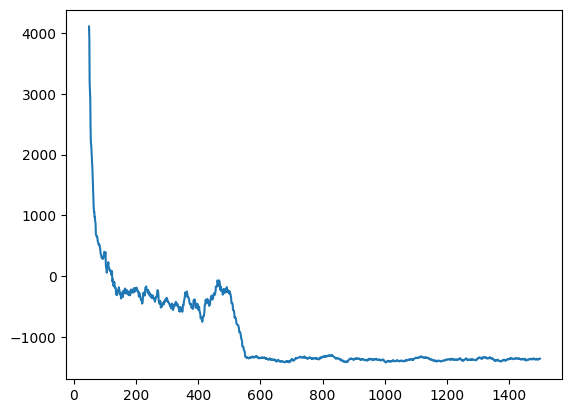

In [20]:
torch.manual_seed(0)
np.random.seed(0)

sgld_model = StochasticVolatility(torch_data.shape, sigma_lambda=10., nu_lambda=0.1)
lr = 0.001
burnin = 500

optimizer = SGLD(sgld_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, 
                                        lr_lambda=lambda epoch: compute_lr(epoch, burnin=burnin, start=1.0))

epoch = 0
sgld_loss_seq = []
sgld_samples = []
for epoch in range(1500):
    print(f'========================================')
    sgld_model.zero_grad()
    
    r_samples, vol_samples = sgld_model()
    loss = sgld_model.loss(torch_data, vol_samples)
    loss.backward()
        
    optimizer.step()
    scheduler.step()

    print(f'[epoch={epoch+1}] loss: {loss.item():.5f}, last_lr: {scheduler.get_last_lr()}')
    sgld_loss_seq.append(loss.item())
    
    params = {name: param.item() for name, param in sgld_model.named_parameters() if name != 'vol_mean'}
    vol = {f'vol_{i}':val for i, val in enumerate(sgld_model.vol_mean.cpu().detach().numpy())}
    params.update(vol)
    sgld_samples.append(params)
    
for name, param in sgld_model.named_parameters():
    print(f'{name} = {param}')

sgld_loss_seq = pd.Series(sgld_loss_seq)
sgld_loss_seq.rolling(50).mean().plot()

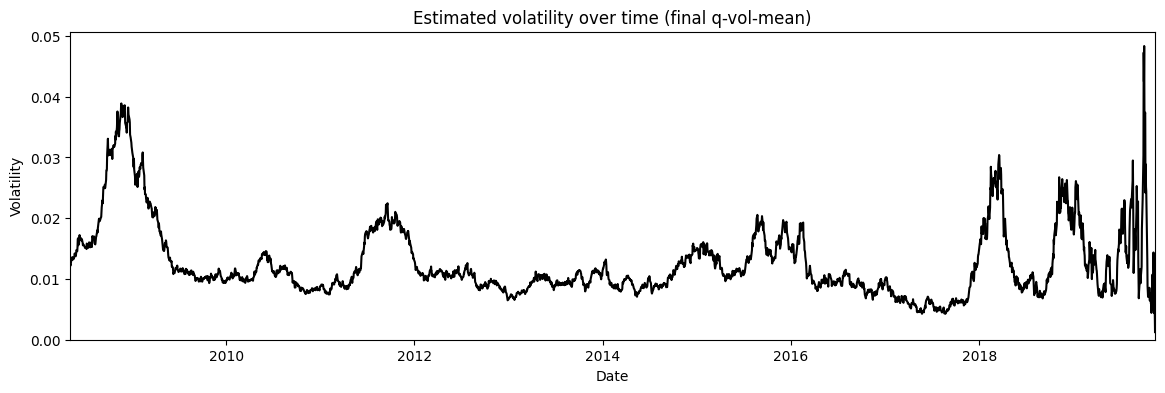

In [21]:
vol_mean = sgld_model.init_vol + torch.cumsum(sgld_model.vol_mean, dim=0) 

fig, ax = plt.subplots(figsize=(14, 4))
y_vals = np.exp(vol_mean.cpu().detach().numpy())
x_vals = returns.index.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k")#, alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time (final q-vol-mean)", xlabel="Date", ylabel="Volatility");

In [22]:
df_sgld = pd.DataFrame(sgld_samples[burnin:])
display(df_sgld.describe())
df_sgld.head(1)

,sigma,nu,init_vol,vol_0,vol_1,vol_2,vol_3,vol_4,vol_5,vol_6,...,vol_2895,vol_2896,vol_2897,vol_2898,vol_2899,vol_2900,vol_2901,vol_2902,vol_2903,vol_2904
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.025566,9.749939,-4.470859,0.032415,0.013721,-0.001750,0.025760,0.030152,0.046708,0.003815,...,0.397946,0.403936,-0.085888,-0.287218,-0.225611,1.099745,-1.202219,0.571407,-0.530038,-1.096922
std,0.000611,0.013945,0.004804,0.004241,0.009187,0.008828,0.006051,0.002226,0.003492,0.003404,...,0.025168,0.036034,0.053148,0.035511,0.030727,0.073837,0.067389,0.058695,0.060220,0.184355
min,0.024592,9.722662,-4.479314,0.023919,0.000532,-0.015816,0.013627,0.024289,0.037820,-0.007386,...,0.310661,0.336212,-0.238035,-0.384003,-0.322889,0.976833,-1.295781,0.406406,-0.713502,-1.342545
25%,0.025165,9.741545,-4.475271,0.028433,0.005877,-0.011202,0.020581,0.028752,0.044699,0.002144,...,0.384886,0.370145,-0.138325,-0.313967,-0.239716,1.033610,-1.247761,0.529049,-0.557835,-1.265904
50%,0.025444,9.748610,-4.470044,0.032511,0.009799,-0.001495,0.027035,0.030048,0.046539,0.004174,...,0.402119,0.405156,-0.074168,-0.281297,-0.224628,1.074607,-1.219814,0.577189,-0.528779,-1.126967
75%,0.025821,9.754597,-4.466928,0.036157,0.023430,0.005543,0.030517,0.031210,0.048241,0.006133,...,0.414497,0.434339,-0.040386,-0.258795,-0.206938,1.178875,-1.194043,0.607195,-0.492914,-0.964651
max,0.028791,9.818289,-4.461549,0.041786,0.029604,0.015593,0.039128,0.037214,0.055480,0.012127,...,0.448051,0.479699,-0.001604,-0.199867,-0.121638,1.224713,-1.013657,0.703437,-0.368670,-0.689896


,sigma,nu,init_vol,vol_0,vol_1,vol_2,vol_3,vol_4,vol_5,vol_6,...,vol_2895,vol_2896,vol_2897,vol_2898,vol_2899,vol_2900,vol_2901,vol_2902,vol_2903,vol_2904
0,0.027036,9.814028,-4.471327,0.03801,0.007328,0.015593,0.039128,0.03039,0.045249,-0.002219,...,0.363656,0.391291,-0.220078,-0.239766,-0.121638,1.081764,-1.069909,0.523141,-0.488485,-0.731033


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
count,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,...,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000
mean,0.148321,0.026798,0.014053,0.014566,0.014427,0.012769,0.013570,0.016476,0.015912,0.015081,...,0.012600,0.012423,0.012470,0.012251,0.012357,0.012651,0.013416,0.012902,0.012558,0.012609
std,0.211974,0.020460,0.007379,0.007720,0.007275,0.006219,0.006346,0.007664,0.007381,0.007105,...,0.006231,0.006161,0.006198,0.006084,0.006089,0.006253,0.006437,0.006178,0.006039,0.006011
min,0.011875,0.008351,0.005359,0.005352,0.004797,0.003301,0.003263,0.004888,0.004669,0.004220,...,0.001363,0.001374,0.001442,0.001353,0.001309,0.001451,0.001581,0.001368,0.001243,0.001251
25%,0.031280,0.014127,0.009177,0.009478,0.009748,0.008960,0.009623,0.011254,0.010931,0.010429,...,0.008742,0.008603,0.008645,0.008498,0.008580,0.008784,0.009437,0.009090,0.008854,0.008968
50%,0.052672,0.019391,0.011457,0.011872,0.011871,0.010819,0.011572,0.013833,0.013437,0.012736,...,0.010460,0.010354,0.010370,0.010218,0.010348,0.010549,0.011168,0.010813,0.010552,0.010686
75%,0.154705,0.031439,0.016753,0.017344,0.017169,0.014746,0.015942,0.019524,0.018819,0.017705,...,0.014596,0.014345,0.014485,0.014168,0.014281,0.014571,0.015541,0.015024,0.014499,0.014722
max,2.089648,0.210877,0.070161,0.073138,0.065595,0.044914,0.046071,0.068433,0.065184,0.061310,...,0.053234,0.051426,0.052792,0.050061,0.049220,0.053676,0.057492,0.051745,0.048511,0.048333


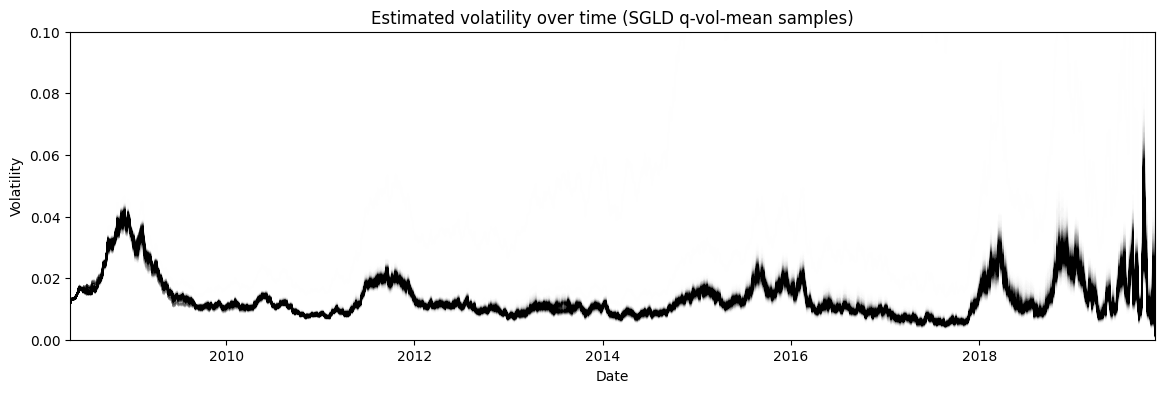

In [23]:
df = df_sgld[[col for col in df_sgld.columns if col.startswith('vol')]].copy()
df = df.cumsum(axis=1).add(df_sgld.init_vol, axis=0)
df_vol = np.exp(df)
df_vol = df_vol.transpose(copy=True)
df_vol.index = list(range(len(df_vol.index)))
display(df_vol.describe())

fig, ax = plt.subplots(figsize=(14, 4))

y_vals = df_vol
time_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5)).time
x_vals = time_vals.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0, top=0.10)
ax.set(title="Estimated volatility over time (SGLD q-vol-mean samples)", xlabel="Date", ylabel="Volatility");

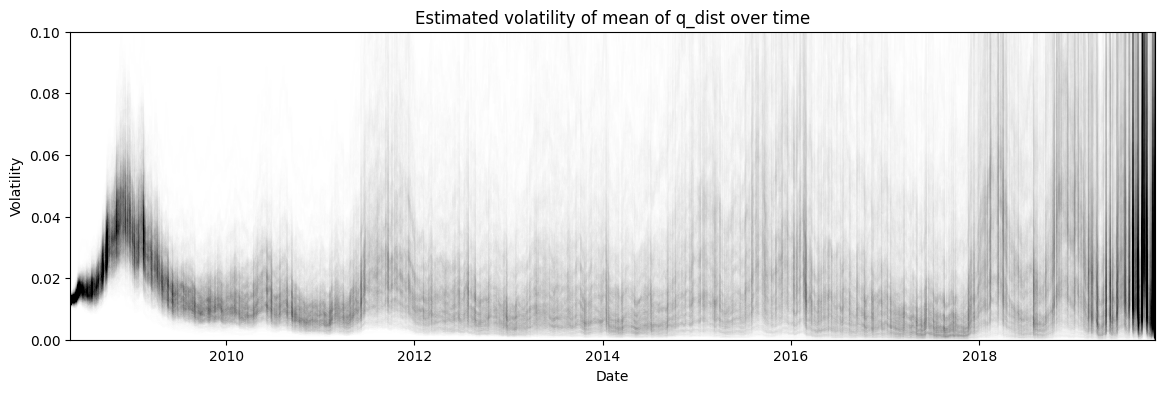

In [24]:
df = df_sgld[[col for col in df_sgld.columns if col.startswith('vol_')]].copy()
sigma_samples = df_sgld['sigma']
random_comp = np.random.normal(np.zeros(sigma_samples.shape),
                               sigma_samples,
                               size=(len(df.columns), len(sigma_samples)))
df = df + np.transpose(random_comp)
df = df.cumsum(axis=1).add(df_sgld.init_vol, axis=0)

df_vol = np.exp(df)
df_vol = df_vol.transpose(copy=True)
df_vol.index = list(range(len(df_vol.index)))

fig, ax = plt.subplots(figsize=(14, 4))

y_vals = df_vol
time_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5)).time
x_vals = time_vals.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0, top=0.10)
ax.set(title="Estimated volatility of mean of q_dist over time", xlabel="Date", ylabel="Volatility");

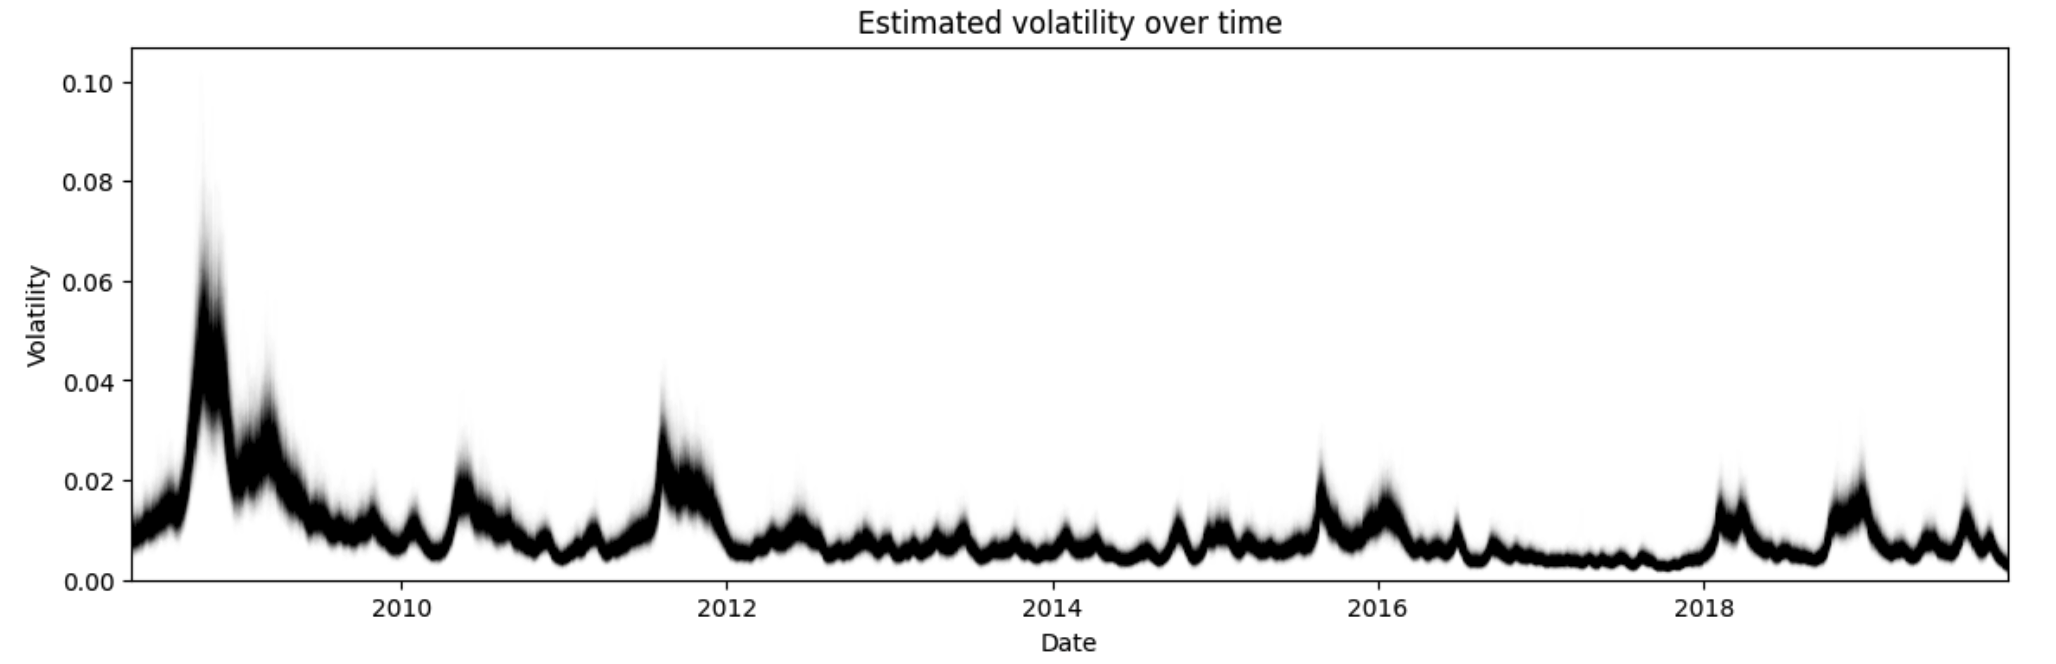

Text(0.5, 0.98, 'Estimated step size (sigma) density')

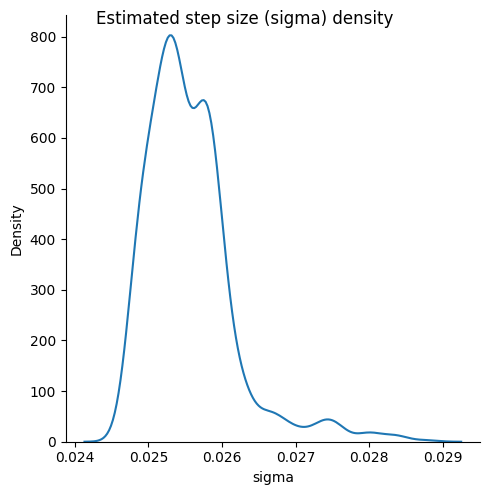

In [25]:
g = sns.displot(df_sgld['sigma'], kind='kde')
g.fig.suptitle("Estimated step size (sigma) density")

Text(0.5, 0.98, 'Estimated degrees freedom (nu) density')

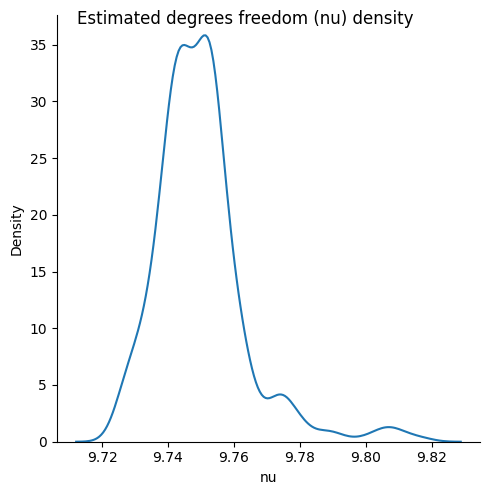

In [26]:
g = sns.displot(df_sgld['nu'], kind='kde')
g.fig.suptitle("Estimated degrees freedom (nu) density")

Text(0.5, 0.98, 'Estimated initial volatility density')

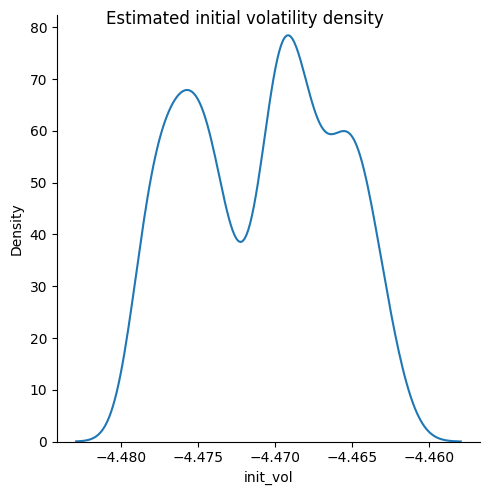

In [27]:
g = sns.displot(df_sgld['init_vol'], kind='kde')
g.fig.suptitle("Estimated initial volatility density")

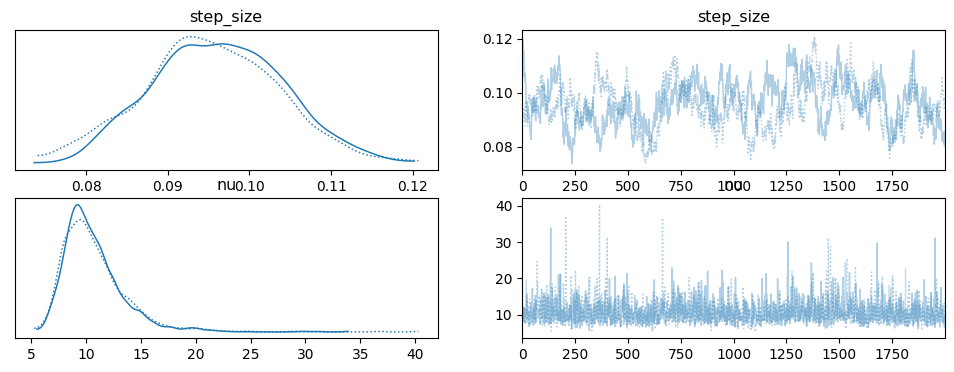

# 2022-11-20

* Re-thought how to do a hierarchical model -- even with SGLD, you still need to use variational inference + KL divergence to approximate it
* Using a simple Gaussian doesn't seem to capture the variance (especially with a single sigma value for all time frames)

TODO:

* Fix up second SGLD graph to include the cumsum -- does directly using the vol_samples work?  The variance would grow with each time frame though, which is exactly what I would expect to observe... not sure

# 2022-11-12

* Had a conceptual bug where I was putting a "prior" on the volatility, even though it's completely specified from the sigma -- that's what happens when I don't actual write out the math first
* I also increased the batch size to 100, it seems to have stabilizing effect so that the loss is less noisy -- this is exatly what I was hoping for but didn't play around with it until now (had it at 10 for a while)
* I also added a random seed to be able to reproduce the same run
* I also "tuned" the number of epochs with regular SGD -- I just kept trying to find a number that looked similar to the estimated volatility over time.
    * It's a bit fickle because the randomness of the vol sampling moves it around a bit
    * Also, I can keep running SGD and lowering the loss but the plot doesn't at all look like the volatility --it just keeps getting smaller
    * I think it it may be because the output is a t-distributed with zero mean, so making the vol smaller (and deg freedom) make the loss lower (I think?)
* With those changes, I get something that *sort of* resembles the volatility from HMC, except:
    * The start of the series has lower volatility -- could be because it's hard to back propagate towards there?
    * The end of the series has really high volatility compared to HMC -- could be some instability
   
-----   

* Also flipped `sigma` and `nu` so they are not reciprocal (mistakenly made them the parameters of the exponential distribution, but I didn't need to because they are "leaf" nodes in the DAG.
    * Had to clip `sigma` to be >= eps or else I get error
    * Now `nu` is rightfully staying around 9.x, but sigma goes to zero (e.g. 1e-7) -- need some more debugging here
    * BUT volatility looks pretty close to the previous shape
    * And loss goes does pretty low (around -9000)

TODO: 

* Debug why sigma goes to zero...
    * Try dividing sigma gradient by number of time frames?
    * Possibly because of RMSProp normalizing it?


# 2022-11-11

* Had a bug in SGLD optimizer where I wasn't actually adding noise to the parameter -- fixed now
* The paper "Preconditioned Stochastic Gradient Langevin Dynamics for Deep Neural Networks", also mentions the concept of "burnin" and "thinning" same as MCMC
* Set burnin = 500, and thinning to 10, One of the runs had the resulting graph is below
* I still get a ton of variance at the tail end because of the random walk
    * It may be the additional variance I add because of the "reparameterization" trick I need to do with the intermediate variables
    

TODO: 

* Do some cleanup

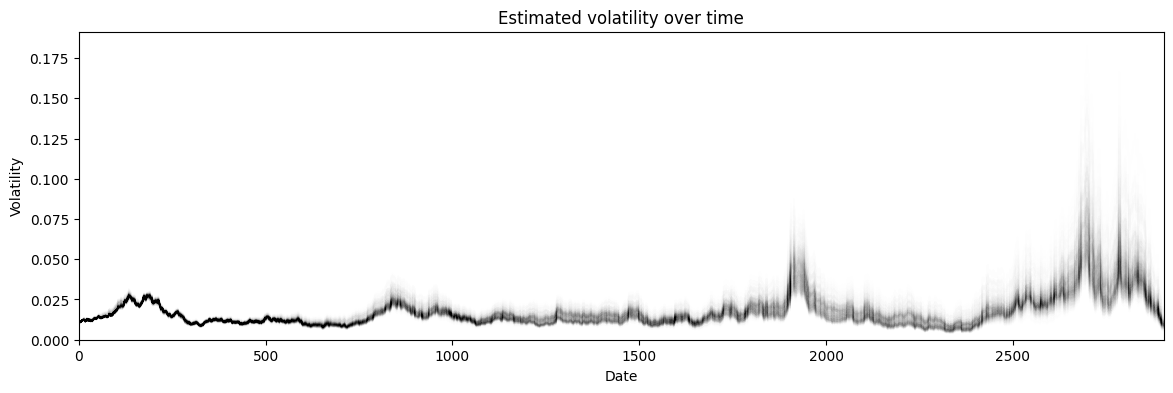

# 2022-11-10

* Not getting a big range of uncertainty (see figure).  Could be the noise term is too small?
* It makes sense that the uncertainty is bigger in later time steps because its variance is dependent on all previous timesteps -- how come it doesn't show up in MCMC though?

TODO: 

* Still need to investigate

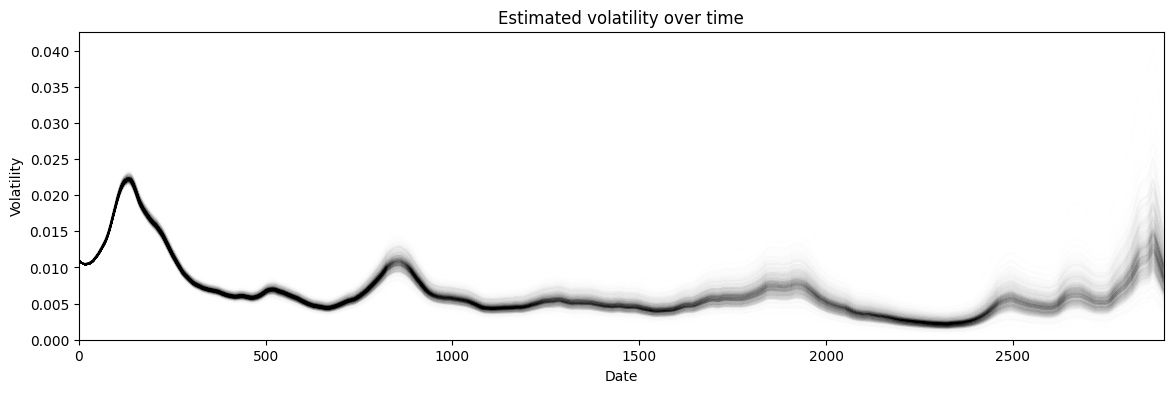

# 2022-11-09

* Generated samples from SGLD and put them in a dataframe

TODO: 

* Take a look to see if it at all resembles the MCMC method

# 2022-11-04

* Implemented the noise optimizer (I think it's working?)

TODO:

* Have to adjust the learning schedule accordingly, will have to figure out what that looks like...

# 2022-11-02

* To implement SGLD, I just really need to add in the noise term
    * I can do this by just inheriting from the Adam class and add the noise term.
* To implement the RMSProp (I'll be using ADAM) preconditioning, looks like I just need to adjust the learning rate
    * I should be able to modify my optimizer class

TODO:
* Implement the optimizer
* Figure out what LR schedule I actually need

# 2022-10-30

* I realized `nu` was off because it close to 2 (instead of the MAP in the model which is around 10)
* After further investigation, it looks like the mode of the posteriod (MAP estimate) shrinks `sigma` and `nu` (the random variables, not the parameters, which is the inverse) to 0.  So there must be a MODE collapse?
* Actually, this happened after I removed the `rsample()` from `nu` and `sigma`.  Adding them back probably slows the rate of decrease down, but probably not eliminates this effect.
* The priors for sure shrink them down to 0 (exponential distribution)
* It kind of looks like the likelihood also does as well?  
    * It's kind of hard to tell because of the indirection, but it's likely that it's at least true for `nu`, which wants to get "fatter" with a higher `nu`, which makes sense given that volatility is always relatively big and not close to 0.

# 2022-10-29

* Think I fixed it to work with batch updating:
    * Got rid of the superfluous `.expands()`
    * Loss: 
        * Priors operate directly on the parameters (NOT the reparameterized samples)
        * Had a bug where I was not using the diff as a prior (because I was using samples, not parameter values)
    * Use ADAM -- this was really important!  I got something *close* to the shape of HMC once every 10 runs or so.  Switching to ADAM, I pretty much the same shape every time.  It makes sense since the parameters probably have such different gradients due to the long chain, and probably having their own learning rates really makes a big difference.
    
TODO:
* Clean up code
* Move on to try SGLD, probably will need that extension paper where they use RMSProp instead of preconditioning matrix.
    
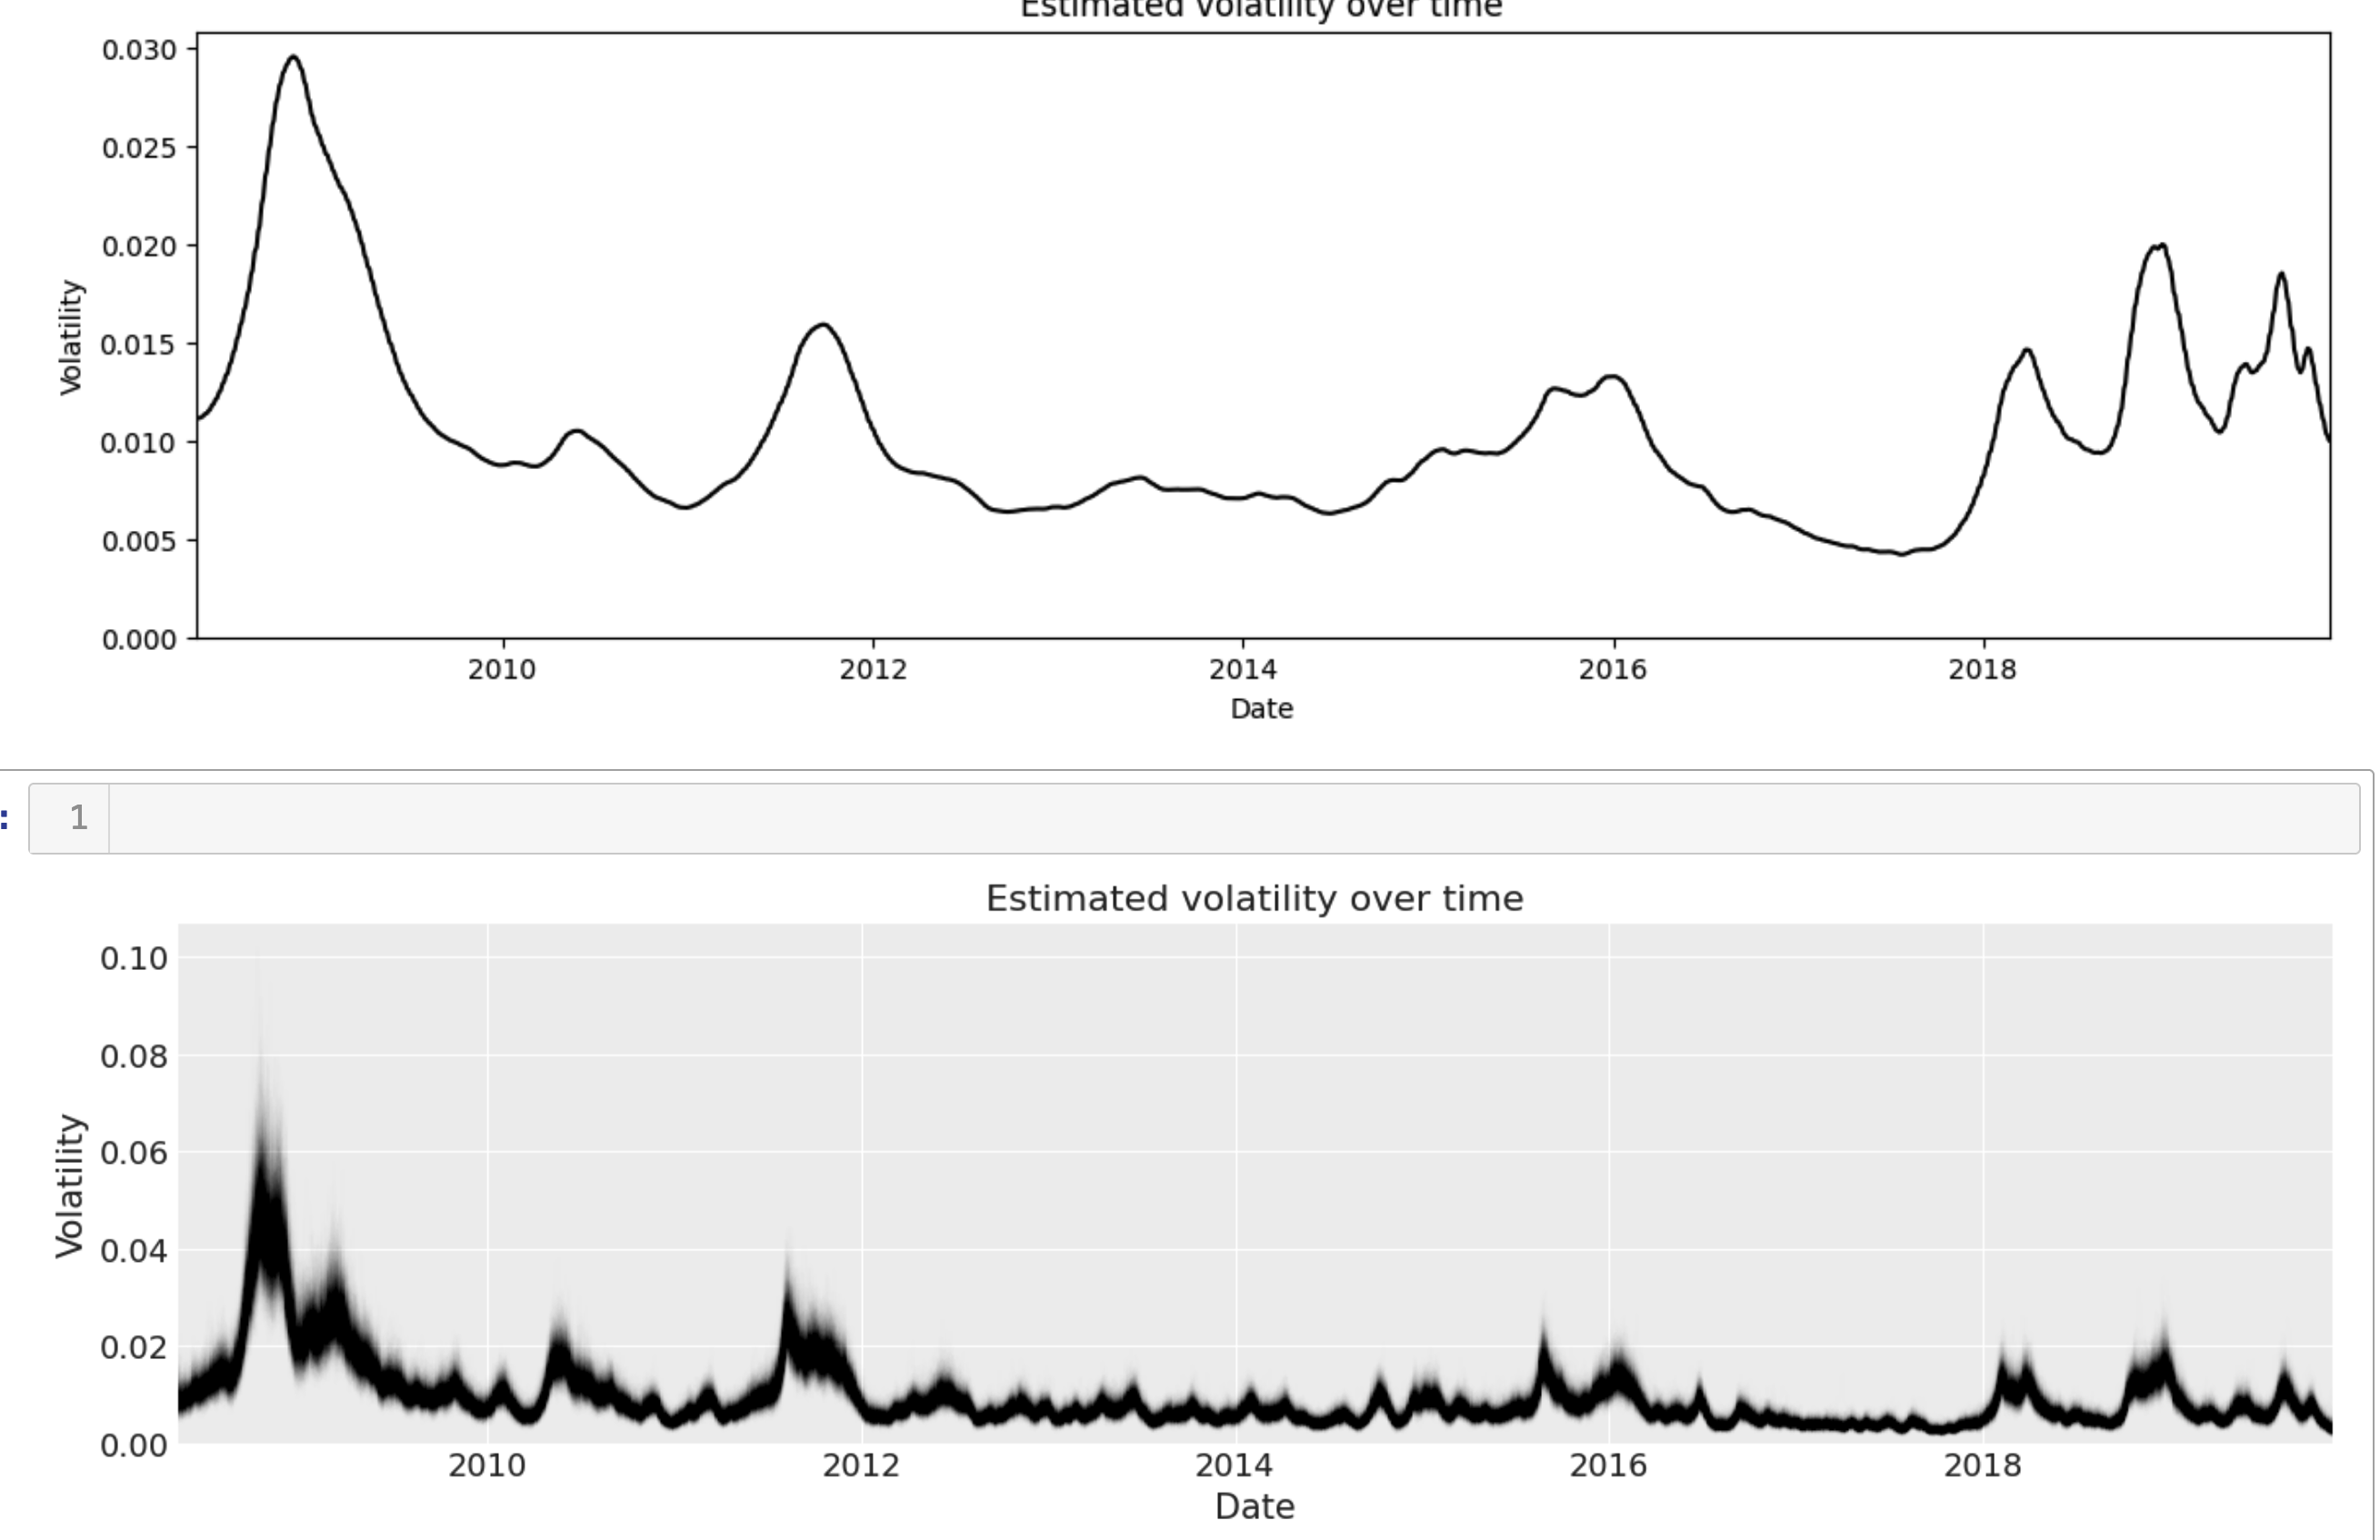


# 2022-10-24

* Fixed up some things in batch implementation, don't use `expand()` because it may have been not back proping through (not sure about that)
    * But using the cleaner method of just using `rsample(sample_size=...)` instead to generate batch needed
* Results still look kind of wrong since I can't mimic the stochastic volatility shape anymore (but the `lambda` and `nu` parameters are very close to the HMC modes / MAP).

TODO:
* Validate each of the batch calculations to make sure I'm generating the right value

# 2022-10-23

* Added `rsample()` to degrees freedom
* With the new changes it gets to the right place... sometimes:
    * There is a lot of variance based on the samples that are drawn from `rsample` and sometimes I get a low-ish loss that is similar in shape, sometimes I get something totally off
* I tried implementing "batch-ing" to average over multiple draws, but it doesn't seem to be learning that fast.

TODO:
* Validate my batch-ing implementation and figure out why it's not learning very fast

# 2022-10-22

* Found another conceptual difference.  I need to sample from each random variable in my DAG using `::rsample()`.
  * So the actual parameters in my torch model are simply the parameters of the random variables (e.g. `sigma` is rate of my exponential step size dist, `self.vol` is mean for the random walk gaussians etc.)
  * So to do a forward pass, I sample from rate, then I sample from vol, then I sample from t-dist (and sample from degrees freedom somewhere)
  * This fixed a lot of issues:
       * We can now backprop all the way through to `self.sigma` instead of only through prior regularizer
       * Misintepreted sigma to be the sample, NOT the rate parameter

TODO:
* Take a look at results in more detail
* May have to do SGD batch-like behavior so that we can smooth the gradient updates (and to smooth the `rsamples`)

# 2022-10-20

* Realized `self.vol` was really just the differences between normal distributions, so the prior can just be evaluated using the $N(0, \sigma^2)$ distribution, simplifying the logic
* I realized the initial value of the Gaussian random walk matters a lot, otherwise there is a discontinuity in the first time step, which throws everything off.  I set it at roughly $log(0.01)$, which is close to the first value I see in the MCMC simulation. 
    * It roughly follows the shape of the posterior from MCMC
    * The scale is off though, most likely because $\sigma$ is very small -- still need to figure out what the deal with that is.
    
    
TODO:
* It also looks like the `vol_init` changes very slowly (along with DF).  Why is that?
    * Is this a case of vanishing gradient (it has to backprop through ~3000 timesteps)?
* Why does $\sigma$ always tend towards negative?  Still need to figure this out...


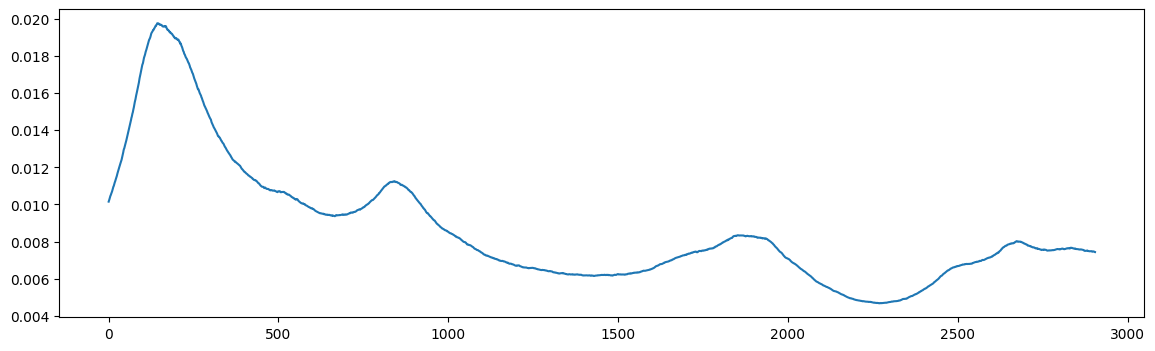

# 2022-10-15

* Fixed: Prior should not be multiplied by len(trace) because $P(X,Y|Z)P(Z) = P(X|Z) P(Y|Z)P(Z)$ where $X$ and $Y$ are conditionally independent given $Z$.  So we only need on prior ($Z$) not one for each of $X,Y$
* Did more debugging, seems like instability in gradient is causing some of my problems
    * See the gradient on sigma blows up for some reason.  Maybe this is like the RNN kind of problem with gradient instability and long traces (we do have a trace of ~3000)

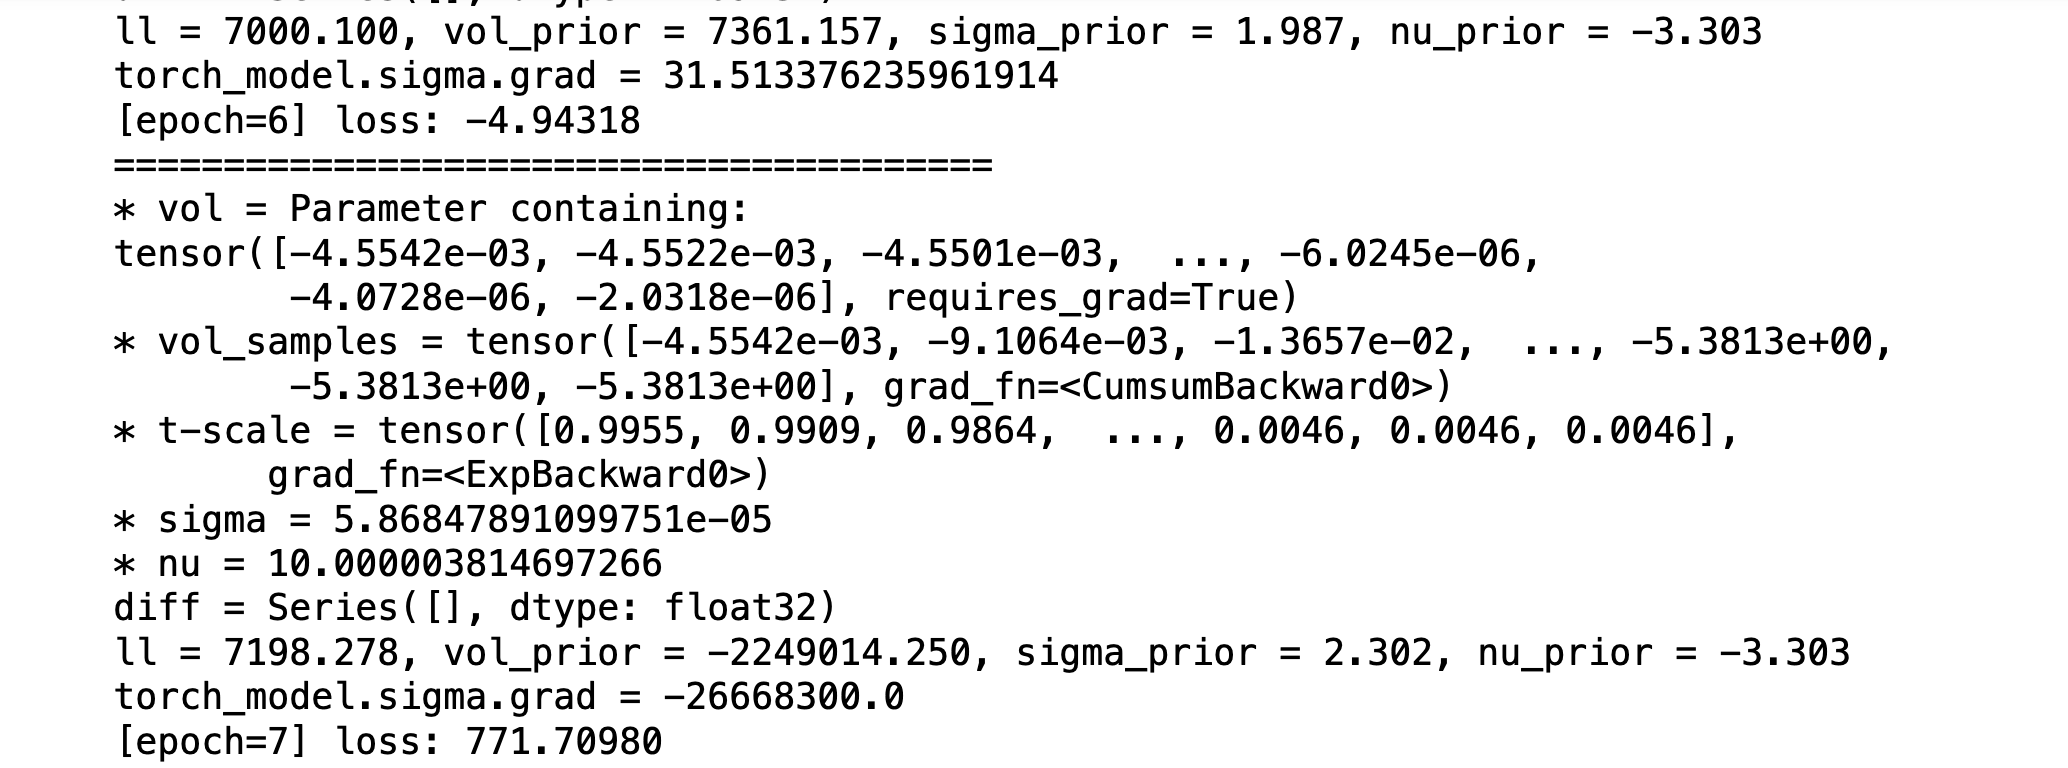

# 2022-10-10

* Had the modelling wrong, I need a Torch parameter for *each* latent variable in the model (not just the top level sigma/nu).  This means I need one for each step of the volatility random walk.
  * I also had a little bug with the reparameterization of t-dist from lambda to sigma (since they are inverse square of each other)
* Got it working, but... I still sometimes get negative values for \sigma since Torch doesn't care if it can eventually go negative.  I think the solution is to re-write it in terms of log(X) where X ~ exponentially distributed. See: https://math.stackexchange.com/questions/2244210/distribution-of-logx-for-exponentially-distributed-x
  * I did a hack by just taking ABS value of sigma, but that doesn't seem right.  Gradient seems off.
* Yeah the gradient of sigma gets huge after it gets close to 0, so I think I need the log parameterization or else the gradient is just going to be crazy.


TODO: 
* Use the log(X) trick to make sure \sigma doesn't go negative
* Double check logic again, sigma keeps going more negative, which is kind of odd why that would happen

# 2022-10-08

* Got the basic framework up for model in PyTorch
* Looks like $sigma$ is going negative though which causes error when used as scale for Gaussian

TODO:

* Double check the model specification, found errors in different parameterization of scales (in Normal and Gaussian)
* Also check loss function is doing what I think it should be...